# Physical AI Spatial Intelligence Warehouse Dataset
For details go to [here](https://huggingface.co/datasets/nvidia/PhysicalAI-Spatial-Intelligence-Warehouse)
### Information
The Physical AI Spatial Intelligence Warehouse is a comprehensive synthetic dataset designed to advance 3D scene understanding in warehouse environments. Generated using ***NVIDIA's Omniverse***, this dataset focuses on ***spatial reasoning through natural language question-answering pairs*** that cover four key categories:
* ***left_right***: understand the spatial relationship between different objects / regions
* ***multi_choice_question(mcq)***: identify the index of target from multiple candidate objects / regions
* ***distance***: estimate the distance (in meters) between different objects / regions
* ***count***: ask about the number of certain type of objects that satisifies the condition (leftmost, specific categories)

Each data point includes:
* RGB-D images
* Object masks
* Natural language Q&A pairs with normalized single-word answers.

The ***annotations*** are automatically generated using ***rule-based templates*** and ***refined using LLMs (Llama-3.1-70B-Instruct)*** for more natural language responses.

### Dataset Qualification: 
* **Training set**: 499k QA pairs
* **Test set**: 19k QA pairs
* **Validation set**: 1.9k QA pairs.
* **Image pair**: 95k RGB-D image pairs in total.

### Annotation Format
Following [LLaVa](https://arxiv.org/abs/2304.08485) format for VLM training. In ***train.json***, and ***val.json***, each sample have:
* ***id***: identity
* ***iamge***: image name
* ***conversations***: chat between human and gpt
* ***rle***:  corresponding masks per object in order following pycoco format
* ***category***: question category
* ***normalized_answer***: for evaluate and submit in single-word answer
* ***freeform_answer***: original answer from 'gpt'

In ***test.json*** only contains: ***id, image, conversations***


## 1. Setup

In [1]:
import json
import os
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm # For progress bars

# For RLE decoding, COCO's pycocotools is standard.
# If not installed: pip install pycocotools
from pycocotools import mask as mask_utils

# --- Configuration ---
BASE_DATA_PATH = 'datasets/PhysicalAI-Spatial-Intelligence-Warehouse/' # Adjust if necessary
TRAIN_JSON_PATH = os.path.join(BASE_DATA_PATH, 'train.json')
VAL_JSON_PATH = os.path.join(BASE_DATA_PATH, 'val.json')
TEST_JSON_PATH = os.path.join(BASE_DATA_PATH, 'test.json') # For later, if needed

IMAGE_BASE_PATH_TRAIN = os.path.join(BASE_DATA_PATH, 'train', 'images')
DEPTH_BASE_PATH_TRAIN = os.path.join(BASE_DATA_PATH, 'train', 'depths')

# Let's set a default figure size for plots
plt.rcParams['figure.figsize'] = (10, 7)

## 2. Loading data

In [2]:
# Load the training JSON data
with open(TRAIN_JSON_PATH, 'r') as f:
    train_data_raw = json.load(f)

# Convert to Pandas DataFrame for easier manipulation
train_df = pd.DataFrame(train_data_raw)

print(f"Number of samples in train_data: {len(train_df)}")
print("\nFirst 5 entries of the training data:")
display(train_df.head())

print("\nColumns in the DataFrame:")
print(train_df.columns)

print("\nInformation about the DataFrame:")
train_df.info()

Number of samples in train_data: 499083

First 5 entries of the training data:


,id,image,conversations,rle,category,normalized_answer,freeform_answer
0,26ba60afef390047b84ee839e8f7cee3,070760.png,"[{'from': 'human', 'value': '<image> Tell me t...","[{'size': [1080, 1920], 'counts': 'k\R?<[Q1010...",distance,2.32,The distance of the pallet [Region 0] from the...
1,8a83907250310dbecd768cc34a3571a8,048440.png,"[{'from': 'human', 'value': 'Looking from this...","[{'size': [1080, 1920], 'counts': 'kSl]15_Q14K...",mcq,0,"Observing from this perspective, the buffer re..."
2,92ba42f4dc21d0b51424aa1b07508536,031691.png,"[{'from': 'human', 'value': 'Among the buffer ...","[{'size': [1080, 1920], 'counts': 'ThkX15_Q14L...",mcq,0,"Looking from this angle, the buffer region [Re..."
3,1fa7f1c49cb50d636863c76548a76599,034173.png,"[{'from': 'human', 'value': 'Which object is t...","[{'size': [1080, 1920], 'counts': 'WlUm0?WQ12O...",mcq,2,"Among the pallet [Region 0], the pallet [Regio..."
4,aa7d4f12b8f02362fc7f759c7d5b4966,043764.png,"[{'from': 'human', 'value': '<image> Among the...","[{'size': [1080, 1920], 'counts': '`jRa17`Q14B...",mcq,0,"Among the pallet [Region 0], the pallet [Regio..."



Columns in the DataFrame:
Index(['id', 'image', 'conversations', 'rle', 'category', 'normalized_answer',
       'freeform_answer'],
      dtype='object')

Information about the DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499083 entries, 0 to 499082
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   id                 499083 non-null  object
 1   image              499083 non-null  object
 2   conversations      499083 non-null  object
 3   rle                499083 non-null  object
 4   category           499083 non-null  object
 5   normalized_answer  499083 non-null  object
 6   freeform_answer    499083 non-null  object
dtypes: object(7)
memory usage: 26.7+ MB


In [ ]:
# train_df.describe()

In [ ]:
# sample 1 entry
train_data_raw[0]

{'id': '26ba60afef390047b84ee839e8f7cee3',
 'image': '070760.png',
 'conversations': [{'from': 'human',
   'value': '<image>\nTell me the distance between the pallet <mask> and the pallet <mask>.'},
  {'from': 'gpt',
   'value': 'The distance of the pallet [Region 0] from the pallet [Region 1] is 2.32 meters.'}],
 'rle': [{'size': [1080, 1920],
   'counts': 'k\\R?<[Q1010O103L3M3N3L3N3L3N2M4L3N2M4M2XQOlNgl0X1WSOgNhl0\\1WSOcNil0_1VSO`Nil0d1USO[Nkl0g1TSOXNkl0k1hROoM]O<dm0h1lROnM_O:cm0k1kROlMC9`m0o1iROjMG7_m0Q2hROiMI6]m0T2gROhML4\\m0W2eROfMO3Zm0Z2dROeM21Xm0]2cROdM5OWm0_2bROcM7NUm0T3kROlLTm0U3lROkLRm0V3oROjLPm0W3PSOiLnl0Y3RSOgLll0[3SSOfLll0[3TSOeLjl0]3VSOcLil0]3XSOcLfl0_3ZSOaLdl0a3\\SO^Ldl0c3\\SO]Lbl0e3^SO[Lal0f3_SOZL_l0i3`SOWL_l0j3aSOVL]l0l3cSOTL[l0n3eSORLZl0o3fSOQLXl0Q4hSOoKWl0R4iSOnKUl0T4kSOkKTl0W4lSOhKTl0Y4lSOeKTl0]4kSObKVl0_4iSOaKVl0a4hSO_KYl0a4fSO_KZl0c4eSO]KZl0P51O010O00010O0011N2O1N3M2O1N2O1N2N2O1N2O1N2O1N2N100O100O1O100O100O010O02N2OO0001K5O1O1N2YJVTO_5kk0aJVTO]5kk0bJWTO]5ik0cJXTO[

## 3. Exploring Fields


---> Detailed view of sample 19 <---
ID: fbd69041ba37ffd380bb3aa320ab1001
Image Filename: 033783.png

Conversations:
  From human: How distant is the pallet <mask> from the pallet <mask>?
  From gpt: The pallet [Region 0] is 5.99 meters away from the pallet [Region 1].

Number of RLE masks: 2

Question Category: distance
Normalized Answer: 5.99
Freeform Answer: The pallet [Region 0] is 5.99 meters away from the pallet [Region 1].

---> Image imformation of sample 19 <---
--- RGB image ---
Format: PNG
Mode: RGB
Size (WxH): (1920, 1080)
Shape: (1080, 1920, 3)
dtype: uint8
Value Min - Max: 0 - 233
--- Depth image ---
Format: PNG
Mode: L
Size (WxH): (1920, 1080)
Shape: (1080, 1920)
dtype: uint8
Value Min - Max: 0 - 255


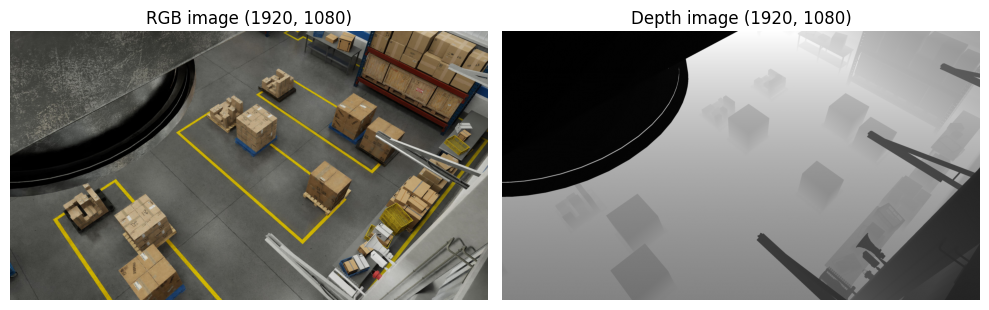

In [ ]:
# Display a single sample for detailed inspection
sample_idx = 19
sample = train_df.iloc[sample_idx]
print(f"\n---> Detailed view of sample {sample_idx} <---")
print(f"ID: {sample['id']}")
print(f"Image Filename: {sample['image']}")

print("\nConversations:")
for turn in sample['conversations']:
    print(f"  From {turn['from']}: {turn['value']}")

print(f"\nNumber of RLE masks: {len(sample['rle'])}")
# print("RLE data for first mask:", sample['rle'][0]) # Can be very long

print(f"\nQuestion Category: {sample['category']}")
print(f"Normalized Answer: {sample['normalized_answer']}")
print(f"Freeform Answer: {sample['freeform_answer']}")

image_path = os.path.join(IMAGE_BASE_PATH_TRAIN, sample['image'])
depth_path = os.path.join(DEPTH_BASE_PATH_TRAIN, sample['image']).replace('.png', '_depth.png')

image = Image.open(image_path)
depth = Image.open(depth_path)

print(f"\n---> Image imformation of sample {sample_idx} <---")
print(f"--- RGB image ---")
print(f"Format: {image.format}")
print(f"Mode: {image.mode}")
print(f"Size (WxH): {image.size}")
print(f"Shape: {np.asarray(image).shape}")
print(f"dtype: {np.asarray(image).dtype}")
print(f"Value Min - Max: {np.asarray(image).min()} - {np.asarray(image).max()}")

print(f"--- Depth image ---")
print(f"Format: {depth.format}")
print(f"Mode: {depth.mode}")
print(f"Size (WxH): {depth.size}")
print(f"Shape: {np.asarray(depth).shape}")
print(f"dtype: {np.asarray(depth).dtype}")
print(f"Value Min - Max: {np.asarray(depth).min()} - {np.asarray(depth).max()}")

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title(f"RGB image {image.size}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(depth, cmap='gray')
plt.title(f"Depth image {depth.size}")
plt.axis('off')
plt.tight_layout()
plt.show()

### 3.1 Question Categories


--- Question Category Analysis ---
Distribution of question categories:
category
distance      245889
mcq           110055
count          73803
left_right     69336
Name: count, dtype: int64


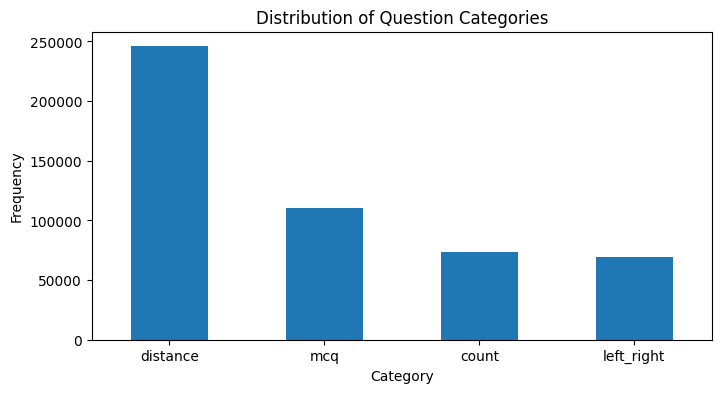

In [ ]:
print("\n--- Question Category Analysis ---")
category_counts = train_df['category'].value_counts()
print("Distribution of question categories:")
print(category_counts)

plt.figure(figsize=(8, 4))
category_counts.plot(kind='bar')
plt.title('Distribution of Question Categories')
plt.ylabel('Frequency')
plt.xlabel('Category')
plt.xticks(rotation=None, ha='center')
plt.tight_layout()
plt.show()

In [ ]:
train_df['num_rle_masks'].value_counts().sort_index()

num_rle_masks
2     227034
3      87953
4      18653
5       6544
6      10203
7      12580
8      21682
9      37946
10     13461
11     14855
12     22905
13     23952
15      1315
Name: count, dtype: int64

### 3.2 Normalized Answers


--- Normalized Answer Analysis ---

Distribution of normalized answers for 'distance' category:
count    245889.000000
mean          5.705665
std           2.840492
min           0.000000
25%           3.470000
50%           5.460000
75%           8.130000
max          18.370000
Name: normalized_answer, dtype: float64


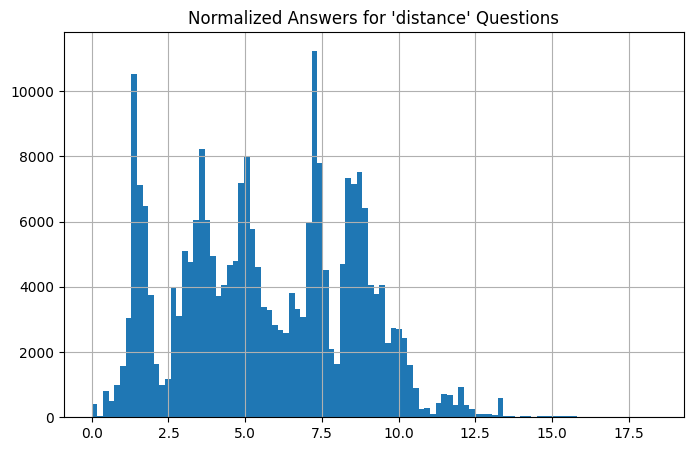


Distribution of normalized answers for 'mcq' category:
normalized_answer
0     34011
1     33690
2     34315
3      2725
4      2096
5      1082
6      1006
7       638
8       193
9       183
10       83
11       15
12       18
Name: count, dtype: int64


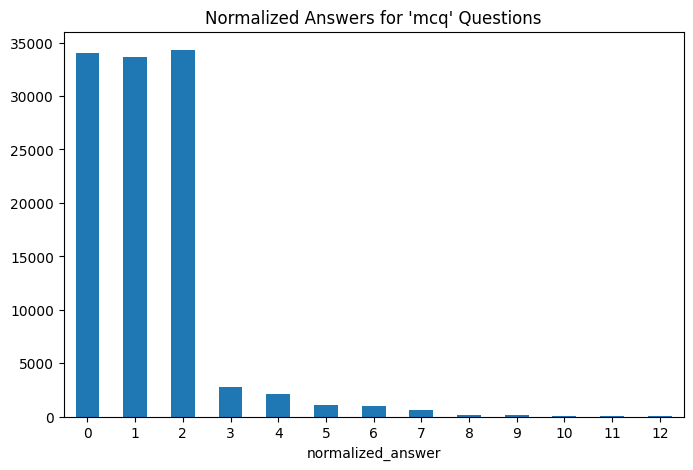


Distribution of normalized answers for 'left_right' category:
normalized_answer
0        3
1    19185
2    15629
3    34421
4     4565
Name: count, dtype: int64


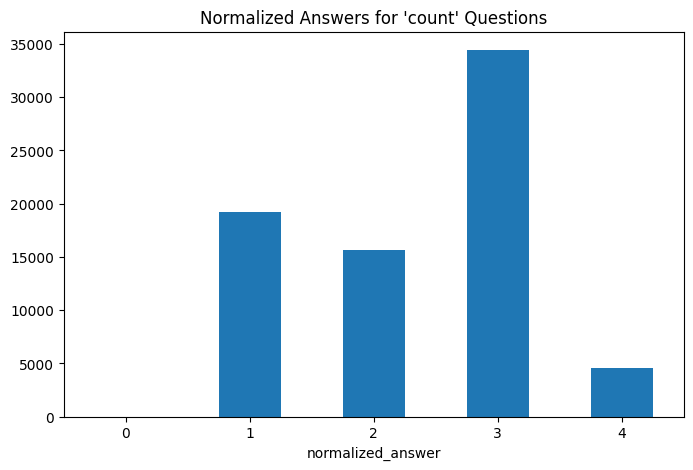


Distribution of normalized answers for 'left_right' category:
normalized_answer
left     34802
right    34534
Name: count, dtype: int64


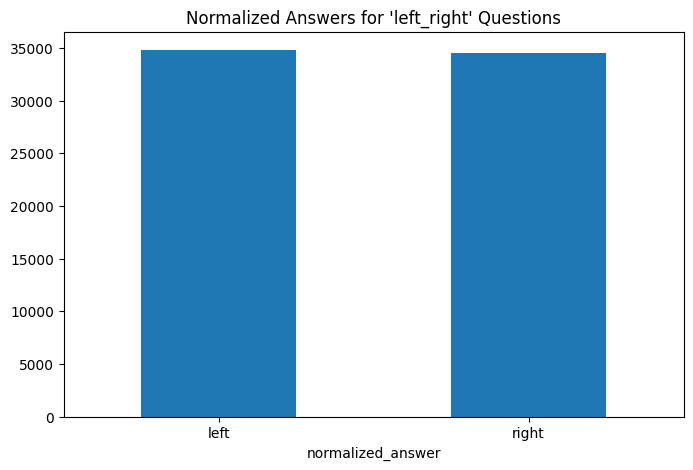


Distribution of number of RLE masks per sample:
num_rle_masks
2     227034
3      87953
4      18653
5       6544
6      10203
7      12580
8      21682
9      37946
10     13461
11     14855
12     22905
13     23952
15      1315
Name: count, dtype: int64


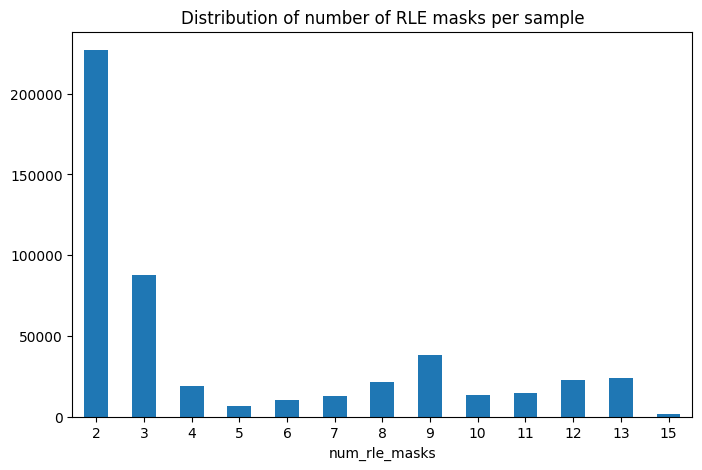

In [ ]:
print("\n--- Normalized Answer Analysis ---")

# distance analysis
distance_answers = train_df[train_df['category'] == 'distance']['normalized_answer'].astype(float)
print("\nDistribution of normalized answers for 'distance' category:")
print(distance_answers.describe())
plt.figure(figsize=(8, 5))
distance_answers.hist(bins=100)
plt.title("Normalized Answers for 'distance' Questions")
plt.xticks(rotation=None, ha='center')
plt.show()

# multiple choice question (mcp) analysis
mcq_answers = train_df[train_df['category'] == 'mcq']['normalized_answer'].astype(int).value_counts().sort_index()
print("\nDistribution of normalized answers for 'mcq' category:")
print(mcq_answers)
plt.figure(figsize=(8, 5))
mcq_answers.plot(kind='bar')
plt.title("Normalized Answers for 'mcq' Questions")
plt.xticks(rotation=None, ha='center')
plt.show()

# count analysis
count_answers = train_df[train_df['category'] == 'count']['normalized_answer'].astype(int).value_counts().sort_index()
print("\nDistribution of normalized answers for 'left_right' category:")
print(count_answers)
plt.figure(figsize=(8, 5))
count_answers.plot(kind='bar')
plt.title("Normalized Answers for 'count' Questions")
plt.xticks(rotation=None, ha='center')
plt.show()

# left_right analysis
left_right_answers = train_df[train_df['category'] == 'left_right']['normalized_answer'].value_counts()
print("\nDistribution of normalized answers for 'left_right' category:")
print(left_right_answers)
plt.figure(figsize=(8, 5))
left_right_answers.plot(kind='bar')
plt.title("Normalized Answers for 'left_right' Questions")
plt.xticks(rotation=None, ha='center')
plt.show()

# Analyze number of RLE masks per sample
train_df['num_rle_masks'] = train_df['rle'].apply(len)
print("\nDistribution of number of RLE masks per sample:")
mask_analysis = train_df['num_rle_masks'].value_counts().sort_index()
print(mask_analysis)
plt.figure(figsize=(8, 5))
mask_analysis.plot(kind='bar')
plt.title("Distribution of number of RLE masks per sample")
plt.xticks(rotation=None, ha='center')
plt.show()

## 4. Image and Depth map


--- Visualizing Image and Depth for 033783.png ---


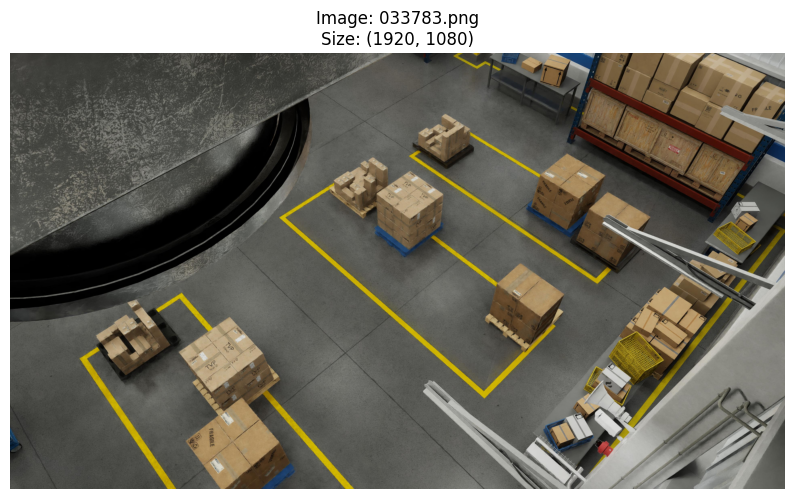

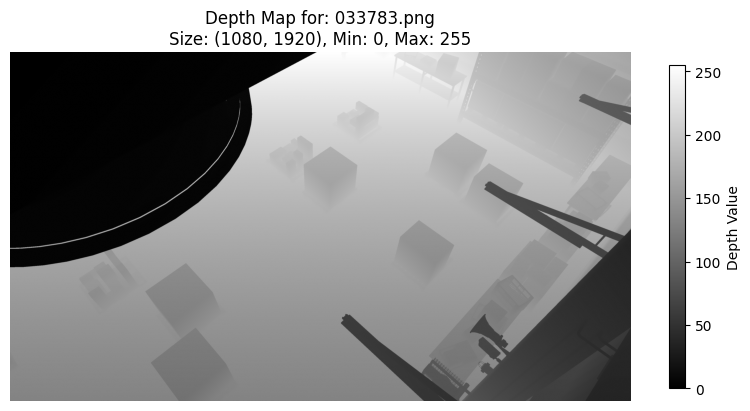

In [ ]:
def load_and_display_image(image_filename, data_split='train'):
    base_path = IMAGE_BASE_PATH_TRAIN if data_split == 'train' else IMAGE_BASE_PATH_VAL # Add other splits
    img_path = os.path.join(base_path, image_filename)
    if not os.path.exists(img_path):
        print(f"Image not found: {img_path}")
        return None, None
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title(f"Image: {image_filename}\nSize: {img.size}")
    plt.axis('off')
    plt.show()
    return img

def load_and_display_depth(image_filename, data_split='train'):
    # Depth images are often saved as .png (16-bit) or .exr (float)
    # The exact way to load and normalize will depend on the format.
    # Assuming .png for now.
    base_path = DEPTH_BASE_PATH_TRAIN if data_split == 'train' else DEPTH_BASE_PATH_VAL # Add other splits
    depth_filename = image_filename.replace('.png', '_depth.png')
    depth_path = os.path.join(base_path, depth_filename)

    if not os.path.exists(depth_path):
        print(f"Depth map not found: {depth_path}")
        return None, None

    # Try loading as a standard image; might need specific library if it's a special format
    depth_img_pil = Image.open(depth_path)
    depth_map_np = np.array(depth_img_pil)

    plt.imshow(depth_map_np, cmap='gray') # 'viridis' or 'gray' or 'plasma' are common colormaps
    plt.colorbar(label='Depth Value', shrink=0.6)
    plt.title(f"Depth Map for: {image_filename}\nSize: {depth_map_np.shape}, Min: {depth_map_np.min()}, Max: {depth_map_np.max()}")
    plt.axis('off')
    plt.show()
    return depth_map_np

# Display for a sample image
sample_image_filename = train_df.iloc[19]['image']
print(f"\n--- Visualizing Image and Depth for {sample_image_filename} ---")
img_obj = load_and_display_image(sample_image_filename)
depth_map_obj = load_and_display_depth(sample_image_filename)

# Check image dimensions consistency (optional, can be slow for all)
# image_sizes = set()
# for img_name in tqdm(train_df['image'].unique()):
#     try:
#         img_path = os.path.join(IMAGE_BASE_PATH_TRAIN, img_name)
#         with Image.open(img_path) as img:
#             image_sizes.add(img.size)
#     except FileNotFoundError:
#         print(f"Warning: Image {img_name} not found during size check.")
# print("\nUnique image dimensions found:", image_sizes)

## 5. RLE mask


--- Visualizing Image with RLE Masks for 033783.png ---


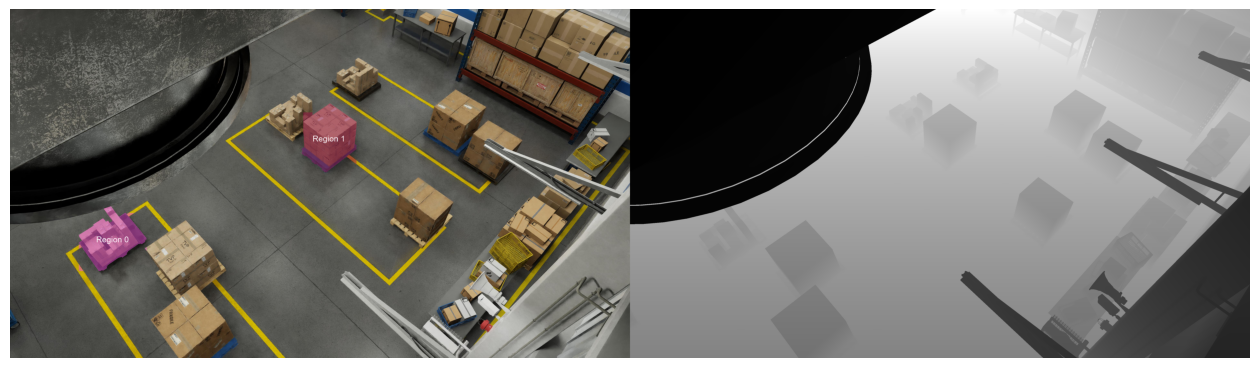

In [ ]:
import pycocotools.mask as mask_utils
from PIL import Image, ImageDraw, ImageFont
import json
import os.path as osp
import numpy as np
import random
import argparse
import os
from tqdm import tqdm

def visualize_masks_and_depth(masks, image_path, depth_path, output_path=None):
    # Load and process RGB image
    image = Image.open(image_path).convert("RGBA")
    overlay = Image.new("RGBA", image.size, (0, 0, 0, 0))
    # font_path = "/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf" # linux
    font_path = "/System/Library/Fonts/Supplemental/Arial.ttf" # for maxos
    font = ImageFont.truetype(font_path, 25)

    text_infos = []

    # Process masks
    for i, mask in enumerate(masks):
        mask = mask_utils.decode(mask)
        mask_image = Image.fromarray((mask * 255).astype(np.uint8), mode='L')
        color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255), 128)  
        colored_mask = Image.new("RGBA", image.size, color)
        overlay.paste(colored_mask, (0, 0), mask_image)

        draw = ImageDraw.Draw(overlay)
        text = f"Region {i}"
        text_size = draw.textbbox((0, 0), text, font=font)
        text_width = text_size[2] - text_size[0]
        text_height = text_size[3] - text_size[1]

        mask_indices = np.argwhere(mask)
        if mask_indices.size > 0:
            min_y, min_x = mask_indices.min(axis=0)
            max_y, max_x = mask_indices.max(axis=0)
            center_x = (min_x + max_x) // 2
            center_y = (min_y + max_y) // 2
            text_position = (center_x - text_width // 2, center_y - text_height // 2)
            text_infos.append((text, text_position))
    
    draw = ImageDraw.Draw(overlay)
    for text, text_position in text_infos:
        draw.text(text_position, text, fill=(255, 255, 255, 255), font=font)

    # Blend RGB image with mask overlay
    blended_image = Image.alpha_composite(image, overlay)

    # Load and process depth image
    depth = np.array(Image.open(depth_path))
    # Normalize depth to 0-255 range for visualization
    depth_min, depth_max = depth.min(), depth.max()
    depth_normalized = ((depth - depth_min) / (depth_max - depth_min) * 255).astype(np.uint8)
    depth_image = Image.fromarray(depth_normalized).convert('RGB')

    # Create side-by-side visualization
    total_width = blended_image.width + depth_image.width
    combined_image = Image.new('RGB', (total_width, blended_image.height))
    combined_image.paste(blended_image, (0, 0))
    combined_image.paste(depth_image, (blended_image.width, 0))

    # Save the combined visualization
    # combined_image.save(output_path)
    plt.figure(figsize=(16, 6))
    plt.imshow(combined_image)
    plt.axis('off')
    plt.show()

# Visualize for a sample with RLE
sample = train_df.iloc[19] 
masks = sample['rle']
image_path = os.path.join(IMAGE_BASE_PATH_TRAIN, sample['image'])
depth_path = os.path.join(DEPTH_BASE_PATH_TRAIN, sample['image']).replace('.png', '_depth.png')

print(f"\n--- Visualizing Image with RLE Masks for {sample['image']} ---")
visualize_masks_and_depth(masks, image_path, depth_path, output_path=None)

### Region Analysis

In [155]:
train_df_distance = train_df[train_df['category'] == 'distance']
train_df_count = train_df[train_df['category'] == 'count']
train_df_mcq = train_df[train_df['category'] == 'mcq']
train_df_lr = train_df[train_df['category'] == 'left_right']

count_region_distance = [len(train_df_distance['rle'].iloc[i]) for i in range(len(train_df_distance))]
count_region_count = [len(train_df_count['rle'].iloc[i]) for i in range(len(train_df_count))]
count_region_mcq = [len(train_df_mcq['rle'].iloc[i]) for i in range(len(train_df_mcq))]
count_region_lr = [len(train_df_lr['rle'].iloc[i]) for i in range(len(train_df_lr))]

count_region_distance[:10]

[2, 2, 2, 2, 2, 10, 2, 2, 2, 13]

In [19]:
train_df_distance.iloc[5]['conversations'], 

([{'from': 'human',
   'value': '<image>\nCan you give me an estimation of the distance between the leftmost pallet and the rightmost pallet among the pallets <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask>?'},
  {'from': 'gpt',
   'value': "From the image's perspective, [Region 4] is the leftmost pallet, and [Region 1] is the rightmost pallet. The distance from the pallet [Region 4] to the pallet [Region 1] is approximately 9.8 meters."}],)

In [20]:
train_df_distance.iloc[9]['conversations']

[{'from': 'human',
  'value': '<image>\nGiven the buffer regions <mask> <mask> <mask> and the pallets <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask>, how far is the rightmost pallet from the leftmost buffer region?'},
 {'from': 'gpt',
  'value': '[Region 11] is the rightmost pallet. [Region 2] is the leftmost buffer region amongall the buffer regions. The distance from the pallet [Region 11] to the buffer region [Region 2] is approximately 6.68 meters.'}]

In [ ]:
train_df_distance = train_df[train_df['category'] == 'distance']

Number of masks in question about Distance:
2     157698
9      15724
4      13779
12      9357
8       9134
7       9020
13      8489
10      7145
6       6934
11      5049
5       3274
3        286
Name: count, dtype: int64
Number of masks in question about Count:
9     19436
13    15213
12    13548
8      8878
11     7388
10     5864
7      1936
15     1315
6       210
5        12
4         3
Name: count, dtype: int64
Number of masks in question about MCQ:
3     87667
4      4871
8      3670
5      3258
6      3059
9      2786
11     2418
7      1624
10      452
13      250
Name: count, dtype: int64
Number of masks in question about Left_Right:
2    69336
Name: count, dtype: int64


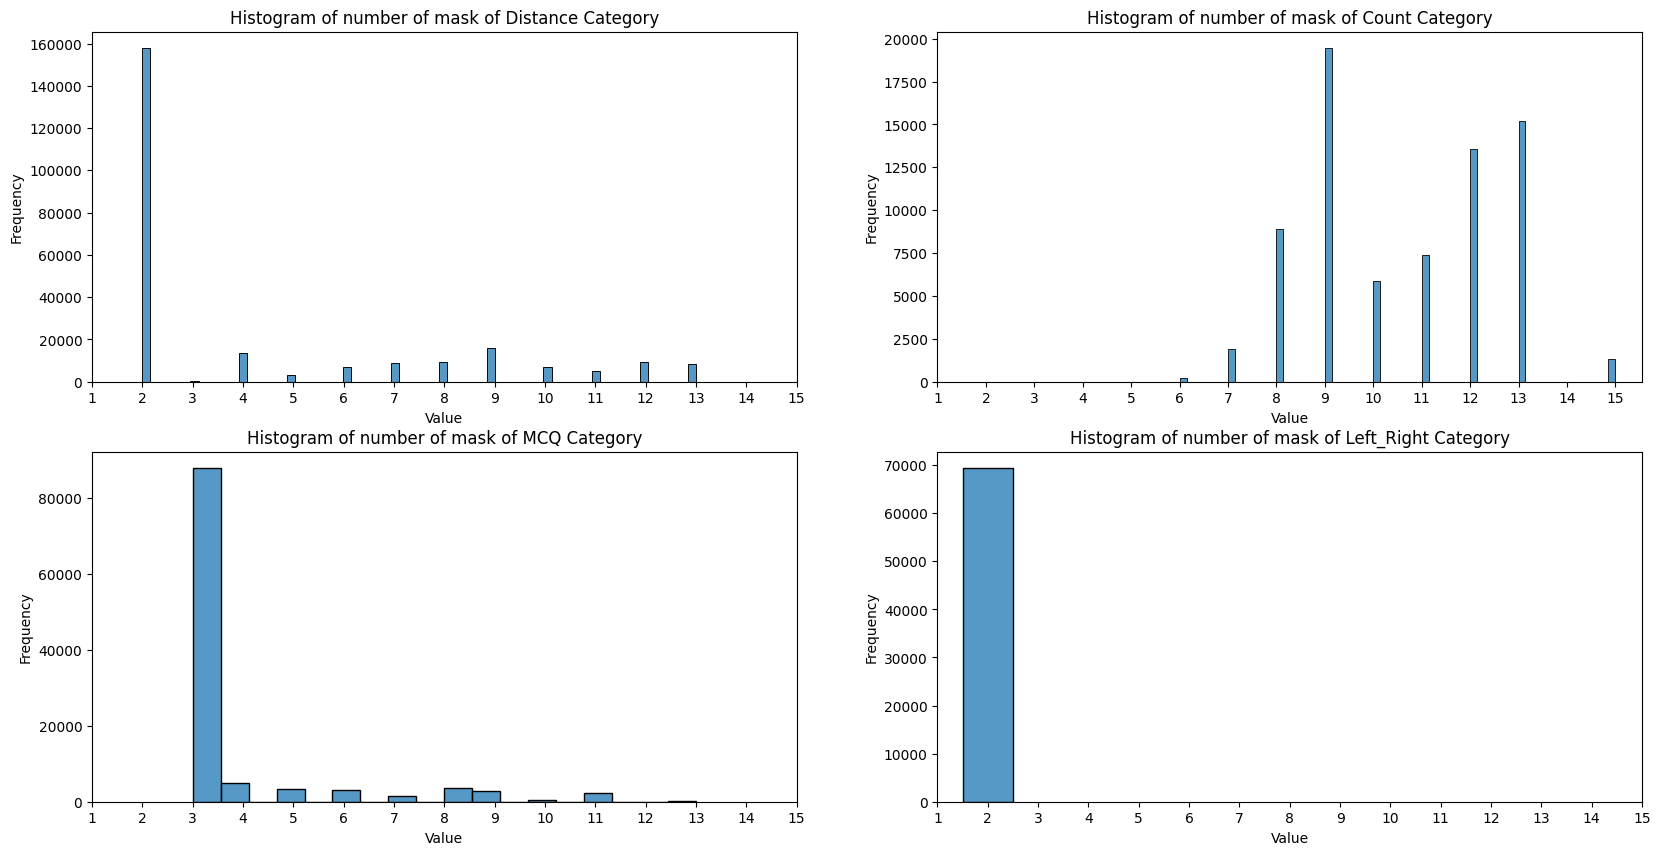

In [172]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

print(f"Number of masks in question about Distance:\n{pd.Series(count_region_distance).value_counts()}")
print(f"Number of masks in question about Count:\n{pd.Series(count_region_count).value_counts()}")
print(f"Number of masks in question about MCQ:\n{pd.Series(count_region_mcq).value_counts()}")
print(f"Number of masks in question about Left_Right:\n{pd.Series(count_region_lr).value_counts()}")

plt.figure(figsize=(20, 10))
plt.subplot(2, 2, 1)
sns.histplot(count_region_distance)
plt.title("Histogram of number of mask of Distance Category")
plt.xlabel("Value")
plt.xticks(np.arange(1, 15 + 1, 1))
plt.ylabel("Frequency")
plt.subplot(2, 2, 2)
sns.histplot(count_region_count)
plt.title("Histogram of number of mask of Count Category")
plt.xlabel("Value")
plt.xticks(np.arange(1, 15 + 1, 1))
plt.ylabel("Frequency")
plt.subplot(2, 2, 3)
sns.histplot(count_region_mcq)
plt.title("Histogram of number of mask of MCQ Category")
plt.xlabel("Value")
plt.xticks(np.arange(1, 15 + 1, 1))
plt.ylabel("Frequency")
plt.subplot(2, 2, 4)
sns.histplot(count_region_lr)
plt.title("Histogram of number of mask of Left_Right Category")
plt.xlabel("Value")
plt.xticks(np.arange(1, 15 + 1, 1))
plt.ylabel("Frequency")
plt.show()

In [28]:
train_df_distance['n_regions'] = count_region

/var/folders/m8/6fld5z8d42q7cprjnz1lpmlr0000gn/T/ipykernel_7665/769709170.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_distance['n_regions'] = count_region


In [29]:
len(train_df_distance), len(count_region)

(245889, 245889)

In [36]:
train_df_distance_more_2 = train_df_distance[train_df_distance['n_regions'] > 2]

In [49]:
import random
idx = random.randint(0, len(train_df_distance_more_2))
train_df_distance_more_2.iloc[idx]['conversations']

[{'from': 'human',
  'value': '<image>\nWhat is the distance of transporter <mask> from the left most buffer region among <mask> <mask> <mask>?'},
 {'from': 'gpt',
  'value': 'The buffer region [Region 3] is the leftmost buffer region from this viewpoint. The distance between transporter [Region 0] and the buffer region [Region 3] is 5.34 meters.'}]

In [145]:
import re

train_df_distance_more_2 = train_df_distance[train_df_distance['n_regions'] > 2]
idx = random.randint(0, len(train_df_distance_more_2))
matches = re.findall(r'\[Region \d+\]', train_df_distance_more_2.iloc[idx]['conversations'][1]['value'])
len(list(set(matches)))

2

In [151]:
count_unique_num_region_in_answer_distance = [len(list(set(
    re.findall(r'\[Region \d+\]', train_df_distance_more_2.iloc[idx]['conversations'][1]['value'])
))) for idx in range(len(train_df_distance_more_2))]

In [152]:
is_all_twos = all(x == 2 for x in count_unique_num_region_in_answer_distance)

print(f"Number region in answer of distance category that have more than 2 region in question always is 2:{is_all_twos}")

Number region in answer of distance category that have more than 2 region in question always is 2:True


## 6. Conversations

In [ ]:
print("\n--- Conversation Analysis ---")

# Extract human questions and gpt answers
train_df['human_question'] = train_df['conversations'].apply(
    lambda conv_list: conv_list[0]['value'] if len(conv_list) > 0 and conv_list[0]['from'] == 'human' else None
)
train_df['gpt_answer'] = train_df['conversations'].apply(
    lambda conv_list: conv_list[1]['value'] if len(conv_list) > 1 and conv_list[1]['from'] == 'gpt' else None
)

print("\nSample questions and answers:")
for i in range(min(5, len(train_df))):
    print(f"Q: {train_df['human_question'].iloc[i]}")
    print(f"A (GPT): {train_df['gpt_answer'].iloc[i]}")
    print(f"A (Normalized): {train_df['normalized_answer'].iloc[i]}")
    print(f"Masks: {train_df['num_rle_masks'].iloc[i]}")
    print("---")

# Check if number of <mask> in question matches number of RLEs or [Region X] in answer
# This is a more involved NLP task but can be approximated.
# For instance, count occurrences of "<mask>" in questions and "[Region" in answers.

def count_mask_tokens(text):
    if text is None: return 0
    return text.count("<mask>")

def count_region_tokens(text):
    if text is None: return 0
    return text.count("[Region")

print(f"="*100)
train_df['num_question_masks'] = train_df['human_question'].apply(count_mask_tokens)
train_df['num_answer_regions'] = train_df['gpt_answer'].apply(count_region_tokens)

print("\nComparison of mask/region counts with RLE counts:")
# Show samples where counts might differ (could indicate complex questions or parsing needs)
mismatch_df = train_df[
    (train_df['num_question_masks'] != train_df['num_rle_masks']) |
    (train_df['num_answer_regions'] != train_df['num_rle_masks'])
]
print(f"Number of samples with potential mismatch in mask/region vs RLE counts: {len(mismatch_df)}")
if not mismatch_df.empty:
    display(mismatch_df[['human_question', 'gpt_answer', 'num_rle_masks', 'num_question_masks', 'num_answer_regions']].head(10))

print(f"="*100)
# Analyze common question structures (more advanced NLP might be needed here)
# For now, let's just see a few unique questions for different categories.
for category in train_df['category'].unique():
    print(f"\n\n{'='*100}\nSample questions for category '{category}':\n{'='*100}")
    sample_questions = train_df[train_df['category'] == category]['human_question'][:10]
    sample_answers = train_df[train_df['category'] == category]['gpt_answer'][:10]
    for q_text, a_text in zip(sample_questions, sample_answers):
        print(f"  Q: {q_text}\n  A: {a_text}\n{'---'}")


--- Conversation Analysis ---

Sample questions and answers:
Q: <image>
Tell me the distance between the pallet <mask> and the pallet <mask>.
A (GPT): The distance of the pallet [Region 0] from the pallet [Region 1] is 2.32 meters.
A (Normalized): 2.32
Masks: 2
---
Q: Looking from this perspective, which of the buffer region <mask>, the buffer region <mask>, and the buffer region <mask> is the rightmost?
A (GPT): Observing from this perspective, the buffer region [Region 0] is the rightmost object.
A (Normalized): 0
Masks: 3
---
Q: Among the buffer region <mask>, the buffer region <mask>, and the buffer region <mask>, which one appears on the rightmost side?
A (GPT): Looking from this angle, the buffer region [Region 0] is the rightmost object.
A (Normalized): 0
Masks: 3
---
Q: Which object is the rightmost among the pallet <mask>, the pallet <mask>, and the pallet <mask> from this viewpoint?
A (GPT): Among the pallet [Region 0], the pallet [Region 1], and the pallet [Region 2], the p

,human_question,gpt_answer,num_rle_masks,num_question_masks,num_answer_regions
1,"Looking from this perspective, which of the bu...","Observing from this perspective, the buffer re...",3,3,1
2,"Among the buffer region <mask>, the buffer reg...","Looking from this angle, the buffer region [Re...",3,3,1
3,Which object is the rightmost among the pallet...,"Among the pallet [Region 0], the pallet [Regio...",3,3,4
4,"<image>\nAmong the pallet <mask>, the pallet <...","Among the pallet [Region 0], the pallet [Regio...",3,3,4
7,"<image>\nFrom the current viewing position, wh...",The pallet [Region 1] is the rightmost object ...,3,3,1
9,<image>\nFrom leftmostthe given buffer masks <...,The buffer region [Region 0] is the leftmost b...,13,13,6
10,<image>\nGiven the buffer regions <mask> <mask...,"From this viewpoint, the buffer region [Region...",9,9,5
12,"Looking from this perspective, which of the pa...","From the image's perspective, the pallet [Regi...",3,3,1
16,<image>\nCan you give me an estimation of the ...,"From the image's perspective, [Region 4] is th...",10,10,4
18,<image>\nConsidering the pallets <mask> <mask>...,"Among the buffer regions, the buffer region [R...",10,10,4




Sample questions for category 'distance':
  Q: <image>
Tell me the distance between the pallet <mask> and the pallet <mask>.
  A: The distance of the pallet [Region 0] from the pallet [Region 1] is 2.32 meters.
---
  Q: How distant is the pallet <mask> from the pallet <mask>?
  A: The pallet [Region 0] and the pallet [Region 1] are 4.90 meters apart.
---
  Q: What is the distance between the pallet <mask> and the pallet <mask>?
  A: The pallet [Region 0] is 8.95 meters from the pallet [Region 1].
---
  Q: How close is the pallet <mask> from the pallet <mask>?
  A: The pallet [Region 0] and the pallet [Region 1] are 6.60 meters apart from each other.
---
  Q: <image>
Can you give me an estimation of the distance between the pallet <mask> and the pallet <mask>?
  A: The distance of the pallet [Region 0] from the pallet [Region 1] is 3.72 meters.
---
  Q: <image>
Can you give me an estimation of the distance between the leftmost pallet and the rightmost pallet among the pallets <mask> <

## 7. Sanity check

In [ ]:
## Check missing image
# print("\n--- Sanity Check: File Existence (sample) ---")
# missing_images = 0
# missing_depths = 0
# for i in range(min(100, len(train_df))): # Check first 100 samples
#     row = train_df.iloc[i]
#     img_path = os.path.join(IMAGE_BASE_PATH_TRAIN, row['image'])
#     depth_path = os.path.join(DEPTH_BASE_PATH_TRAIN, row['image']) # Assuming same name
#     if not os.path.exists(img_path):
#         missing_images += 1
#     if not os.path.exists(depth_path):
#         missing_depths += 1
# print(f"Missing images in first 100 samples: {missing_images}")
# print(f"Missing depth maps in first 100 samples: {missing_depths}")

## 8. Analysis Answer

In [2]:
import random

In [175]:
import json

val_path = "datasets/PhysicalAI-Spatial-Intelligence-Warehouse/val.json"
train_path = "datasets/PhysicalAI-Spatial-Intelligence-Warehouse/train.json"

with open(val_path, 'r') as f:
    val_data = json.load(f)
    
print(f"Number of sample in validation set: {len(val_data)}")
print(f"Columns: {val_data[0].keys()}")


with open(train_path, 'r') as f:
    train_data = json.load(f)
    
print(f"Number of sample in validation set: {len(train_data)}")
print(f"Columns: {train_data[0].keys()}")

Number of sample in validation set: 1942
Columns: dict_keys(['id', 'image', 'conversations', 'rle', 'category', 'normalized_answer', 'freeform_answer'])
Number of sample in validation set: 499083
Columns: dict_keys(['id', 'image', 'conversations', 'rle', 'category', 'normalized_answer', 'freeform_answer'])


In [176]:
import pandas as pd

df_val = pd.DataFrame(val_data)
df_val.head()

df_train = pd.DataFrame(train_data)
df_train.head()

,id,image,conversations,rle,category,normalized_answer,freeform_answer
0,26ba60afef390047b84ee839e8f7cee3,070760.png,"[{'from': 'human', 'value': '<image> Tell me t...","[{'size': [1080, 1920], 'counts': 'k\R?<[Q1010...",distance,2.32,The distance of the pallet [Region 0] from the...
1,8a83907250310dbecd768cc34a3571a8,048440.png,"[{'from': 'human', 'value': 'Looking from this...","[{'size': [1080, 1920], 'counts': 'kSl]15_Q14K...",mcq,0,"Observing from this perspective, the buffer re..."
2,92ba42f4dc21d0b51424aa1b07508536,031691.png,"[{'from': 'human', 'value': 'Among the buffer ...","[{'size': [1080, 1920], 'counts': 'ThkX15_Q14L...",mcq,0,"Looking from this angle, the buffer region [Re..."
3,1fa7f1c49cb50d636863c76548a76599,034173.png,"[{'from': 'human', 'value': 'Which object is t...","[{'size': [1080, 1920], 'counts': 'WlUm0?WQ12O...",mcq,2,"Among the pallet [Region 0], the pallet [Regio..."
4,aa7d4f12b8f02362fc7f759c7d5b4966,043764.png,"[{'from': 'human', 'value': '<image> Among the...","[{'size': [1080, 1920], 'counts': '`jRa17`Q14B...",mcq,0,"Among the pallet [Region 0], the pallet [Regio..."


In [177]:
df_val['category'].value_counts()

category
left_right    500
count         500
distance      486
mcq           456
Name: count, dtype: int64

In [178]:
df_train['category'].value_counts()

category
distance      245889
mcq           110055
count          73803
left_right     69336
Name: count, dtype: int64

### Parser: left_right

In [6]:
df_val_left_right = df_val[df_val['category']=='left_right']
for free, norm in zip(df_val_left_right['freeform_answer'], df_val_left_right['normalized_answer']):
    print(f"{free}\n{norm}")
    break

The pallet [Region 0] is to the left of the pallet [Region 1].
left


In [7]:
df_val_left_right.iloc[0] 

id                                    aff5479b81c95b0194f58dbaaa041332
image                                                       000315.png
conversations        [{'from': 'human', 'value': 'From this viewpoi...
rle                  [{'size': [1080, 1920], 'counts': 'bngl081MYQ1...
category                                                    left_right
normalized_answer                                                 left
freeform_answer      The pallet [Region 0] is to the left of the pa...
Name: 0, dtype: object

In [8]:
idx = [random.randint(0, len(df_val_left_right)) for _ in range(5)]
print(idx)
for i in idx:   
    print(f"Q: {df_val_left_right.iloc[i]['conversations'][0]['value']}\nA: {df_val_left_right.iloc[i]['conversations'][1]['value']}\nN: {df_val_left_right.iloc[i]['normalized_answer']}")
    print('___')

[280, 261, 44, 193, 380]
Q: Is the pallet <mask> to the left of the pallet <mask> from the image's perspective?
A: From this viewpoint, the pallet [Region 0] is on the left of the pallet [Region 1].
N: left
___
Q: From the image's perspective, is the pallet <mask> situated on the left or right of the pallet <mask>?
A: From this viewpoint, the pallet [Region 0] is on the left of the pallet [Region 1].
N: left
___
Q: <image>
Is the buffer region <mask> to the right of the buffer region <mask> from the image's perspective?
A: The buffer region [Region 0] is positioned to the right of the buffer region [Region 1].
N: right
___
Q: Can you determine if the pallet <mask> is to the right of the pallet <mask> based on the current viewing angle?
A: Observing from this perspective, the pallet [Region 0] is on the left of the pallet [Region 1].
N: left
___
Q: Looking from this perspective, is the pallet <mask> to the left of the pallet <mask>?
A: Observing from this perspective, the pallet [Region

In [9]:
def parse_left_right_output(text: str):
    """
    Parses for 'left' or 'right' keywords, with simple negation checking.
    """
    text_lower = text.lower()
    is_negated = "not" in text_lower or "incorrect" in text_lower

    is_left = "left" in text_lower
    is_right = "right" in text_lower

    if is_left and not is_right:
        # e.g., "is to the left", "is not to the right" -> both imply left
        return "right" if is_negated else "left"
    if is_right and not is_left:
        # e.g., "is to the right", "is not to the left" -> both imply right
        return "left" if is_negated else "right"
    
    # If both or neither are present, this simple parser gives up.
    return None

In [10]:
left_right = [parse_left_right_output(sample) for sample in df_val_left_right['freeform_answer']]

In [11]:
df_val_left_right['normalized_answer'].to_list() == left_right

True

In [12]:
df_train_left_right = df_train[df_train['category'] == 'left_right']
print(len(df_train_left_right))
left_right = [parse_left_right_output(sample) for sample in df_train_left_right['freeform_answer']]
df_train_left_right['normalized_answer'].to_list() == left_right

69336


True

In [15]:
norm_left_right = [parse_left_right_output(sample) for sample in df_val_left_right['freeform_answer']]
left_right_answers = df_val_left_right['normalized_answer'].to_list()
count = 0
for i in range(len(df_val_left_right)):
    if df_val_left_right['normalized_answer'].iloc[i] == norm_left_right[i]:
        count += 1
        
    else:
        print(df_val_left_right['conversations'].iloc[i][0]['value'])
        print(df_val_left_right['freeform_answer'].iloc[i])
        print(f"{df_val_left_right['normalized_answer'].iloc[i]} - {df_val_left_right[i]}")
print(count)

500


In [16]:
df_train_left_right = df_train[df_train['category'] == 'left_right']
norm_left_right = [parse_left_right_output(sample) for sample in df_train_left_right['freeform_answer']]
count = 0
for i in range(len(df_train_left_right)):
    if df_train_left_right['normalized_answer'].iloc[i] == norm_left_right[i]:
        count += 1
        
    else:
        print(df_train_left_right['conversations'].iloc[i][0]['value'])
        print(df_train_left_right['freeform_answer'].iloc[i])
        print(f"{df_train_left_right['normalized_answer'].iloc[i]} - {df_train_left_right[i]}")
print(count)

69336


### Parser: distance

In [5]:
df_val_distance = df_val[df_val['category'] == "distance"]
len(df_val_distance)

486

In [6]:
df_train_distance = df_train[df_train['category'] == 'distance']

In [7]:
df_train_distance.head()

,id,image,conversations,rle,category,normalized_answer,freeform_answer
0,26ba60afef390047b84ee839e8f7cee3,070760.png,"[{'from': 'human', 'value': '<image> Tell me t...","[{'size': [1080, 1920], 'counts': 'k\R?<[Q1010...",distance,2.32,The distance of the pallet [Region 0] from the...
5,68593e4a93870a00e675b05598d67fd9,029530.png,"[{'from': 'human', 'value': 'How distant is th...","[{'size': [1080, 1920], 'counts': 'b_oU17b1MYn...",distance,4.9,The pallet [Region 0] and the pallet [Region 1...
8,e5f89953f55e29588e6771e74f3cc652,034676.png,"[{'from': 'human', 'value': 'What is the dista...","[{'size': [1080, 1920], 'counts': '\PUe12dQ13N...",distance,8.95,The pallet [Region 0] is 8.95 meters from the ...
14,b43d2c1267bd7325c5eddf522c58e886,059762.png,"[{'from': 'human', 'value': 'How close is the ...","[{'size': [1080, 1920], 'counts': 'k`ej0>TQ1a0...",distance,6.6,The pallet [Region 0] and the pallet [Region 1...
15,4ea56fdbfceef218ae50846a5e8c80f4,024550.png,"[{'from': 'human', 'value': '<image> Can you g...","[{'size': [1080, 1920], 'counts': 'RjSi0;a0Q1l...",distance,3.72,The distance of the pallet [Region 0] from the...


In [11]:
sample_10_distance = [df_train_distance.iloc[i].to_dict() for i in range(10)]

In [12]:
sample_10_distance

[{'id': '26ba60afef390047b84ee839e8f7cee3',
  'image': '070760.png',
  'conversations': [{'from': 'human',
    'value': '<image>\nTell me the distance between the pallet <mask> and the pallet <mask>.'},
   {'from': 'gpt',
    'value': 'The distance of the pallet [Region 0] from the pallet [Region 1] is 2.32 meters.'}],
  'rle': [{'size': [1080, 1920],
    'counts': 'k\\R?<[Q1010O103L3M3N3L3N3L3N2M4L3N2M4M2XQOlNgl0X1WSOgNhl0\\1WSOcNil0_1VSO`Nil0d1USO[Nkl0g1TSOXNkl0k1hROoM]O<dm0h1lROnM_O:cm0k1kROlMC9`m0o1iROjMG7_m0Q2hROiMI6]m0T2gROhML4\\m0W2eROfMO3Zm0Z2dROeM21Xm0]2cROdM5OWm0_2bROcM7NUm0T3kROlLTm0U3lROkLRm0V3oROjLPm0W3PSOiLnl0Y3RSOgLll0[3SSOfLll0[3TSOeLjl0]3VSOcLil0]3XSOcLfl0_3ZSOaLdl0a3\\SO^Ldl0c3\\SO]Lbl0e3^SO[Lal0f3_SOZL_l0i3`SOWL_l0j3aSOVL]l0l3cSOTL[l0n3eSORLZl0o3fSOQLXl0Q4hSOoKWl0R4iSOnKUl0T4kSOkKTl0W4lSOhKTl0Y4lSOeKTl0]4kSObKVl0_4iSOaKVl0a4hSO_KYl0a4fSO_KZl0c4eSO]KZl0P51O010O00010O0011N2O1N3M2O1N2O1N2N2O1N2O1N2O1N2N100O100O1O100O100O010O02N2OO0001K5O1O1N2YJVTO_5kk0aJVTO]5kk0bJWTO]5i

In [14]:
with open("datasets/PhysicalAI-Spatial-Intelligence-Warehouse/sample_10_distance.json", 'w') as f:
    json.dump(sample_10_distance, f, indent=1)

In [18]:
import re
def parse_distance_output(text: str):
    """
    Parses freeform text to extract a distance value.
    Prioritizes numbers followed by "meter(s)".
    """
    # Pattern to find numbers (integers or decimals) followed by "meter" or "m"
    match = re.search(r"(\d+\.\d+|\d+)\s*(?:meters?|m)\b", text, re.IGNORECASE)
    if match:
        try:
            return float(match.group(1))
        except (ValueError, IndexError):
            pass
    
    # Fallback: search for any number if the primary pattern fails
    # match_any = re.search(r"(\d+\.\d+|\d+)", text)
    # if match_any:
    #     try:
    #         return float(match_any.group(1))
    #     except (ValueError, IndexError):
    #         pass
    return 0

norm_distance = [parse_distance_output(sample) for sample in df_val_distance['freeform_answer']]
distance_answers = df_val_distance['normalized_answer'].to_list()
count = 0
for i in range(len(df_val_distance)):
    if df_val_distance['normalized_answer'].iloc[i] == norm_distance[i]:
        count += 1
        
    else:
        print(df_val_distance['conversations'].iloc[i][0]['value'])
        print(df_val_distance['freeform_answer'].iloc[i])
        print(f"{df_val_distance['normalized_answer'].iloc[i]} - {norm_distance[i]}")
print(count)

486


In [19]:
df_train_distance = df_train[df_train['category'] == 'distance']
norm_distance = [parse_distance_output(sample) for sample in df_train_distance['freeform_answer']]
count = 0
for i in range(len(df_train_distance)):
    if df_train_distance['normalized_answer'].iloc[i] == norm_distance[i]:
        count += 1
        
    else:
        print(df_train_distance['conversations'].iloc[i][0]['value'])
        print(df_train_distance['freeform_answer'].iloc[i])
        print(f"{df_train_distance['normalized_answer'].iloc[i]} - {df_train_distance[i]}")
print(count)

245889


In [20]:
idx = random.randint(0, len(df_val))-5
for conv in df_val_distance['conversations'].to_list()[idx:idx+5]:
    print(conv[0])
    print('___')

In [21]:
for free, norm in zip(df_val_distance['freeform_answer'], df_val_distance['normalized_answer']):
    print(f"{free}\n{norm}")
    break

[Region 9] is the leftmost pallet from this viewpoint, and the shelf [Region 11] is the shelf on the right. The spatial distance between the pallet [Region 9] and the shelf [Region 11] is 13.54 meters.
13.54


### Parser: count

In [179]:
df_val_count = df_val[df_val['category'] == 'count']
len(df_val_count)

500

In [186]:
df_val_count.iloc[0]['conversations'], df_val_count.iloc[1]['conversations'], df_val_count.iloc[2]['conversations']
for i in range(3):
    print(f"Q: {df_val_count.iloc[i]['conversations'][0]['value']}")
    print(f"A: {df_val_count.iloc[i]['conversations'][1]['value']}")
    print("-"*20)

Q: <image>
Using the buffer masks <mask> <mask> <mask> and pallet masks <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask>, how many pallets are situated in the buffer region closest to the shelf on the right among <mask> <mask>?
A: The shelf [Region 14] is the shelf on the right. The buffer region [Region 0] is the closest to the shelf [Region 14]. I see pallets [Region 5] [Region 9] [Region 12] in the buffer region [Region 0]. Hence, in buffer area [Region 0], there are exactly three pallets.
--------------------
Q: <image>
Using the buffer masks <mask> <mask> <mask> and pallet masks <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask>, can you determine how many pallets are inside the leftmost buffer area?
A: From the image's perspective, the buffer region [Region 2] is the leftmost buffer region. There are pallets [Region 5] [Region 10] inside the buffer region [Region 2]. Thus, the buffer region [Region 2] is storing two pallets at the moment.
---------------

In [24]:
str_to_int = {
    'one': 1,
    'two': 2,
    'three': 3,
    'four': 4,
    'five': 5,
    'six': 6,
    'seven': 7,
    'eight': 8,
    'nine': 9,
    'ten': 10,
}

In [25]:
def parse_count_output(text: str):
    """
    Parses freeform text to extract a count. Handles digits and spelled-out numbers.
    """
    
    # text_lower = text.lower()
    # # Prioritize digits in context
    # match_digit = re.search(r"\b(?:is|are|exactly|total of|count of|holds)\s*(\d+)\b", text_lower)
    # if match_digit:
    #     return int(match_digit.group(1))

    # # Fallback to any digit
    # match_digit_fallback = re.search(r"\b(\d+)\b", text_lower)
    # if match_digit_fallback:
    #     return int(match_digit_fallback.group(1))
        
    # # Try to convert spelled-out numbers
    # try:
    #     # This can be slow and sometimes inaccurate on long text,
    #     # so it's best as a fallback or used with more specific regex.
    #     num = w2n.word_to_num(text_lower)
    #     return num
    # except ValueError:
    #     pass
    pattern = r'\b(?:one|two|three|four|five|six|seven|eight|nine|ten|\d+)\s+(?:pallets?|buffer)\b'
    matches = re.findall(pattern, text, flags=re.IGNORECASE)
    count = matches[0].split(' ')[0]
    if count in str_to_int.keys():
        return str_to_int.get(count)
    if count in str_to_int.values():
        return count
    return None
parse_count_output(df_val_count['freeform_answer'].to_list()[0])

3

In [26]:
norm_count = [parse_count_output(sample) for sample in df_val_count['freeform_answer']]
count_answers = df_val_count['normalized_answer'].to_list()
count = 0
for i in range(len(df_val_count)):
    if df_val_count['normalized_answer'].iloc[i] == norm_count[i]:
        count += 1
        
    else:
        print(df_val_count['conversations'].iloc[i][0]['value'])
        print(df_val_count['freeform_answer'].iloc[i])
        print(f"{df_val_count['normalized_answer'].iloc[i]} - {norm_count[i]}")
print(count)

500


In [30]:
df_train_count = df_train[df_train['category'] == 'count']
print(f"len count category: {len(df_train_count)}")
norm_count = [parse_count_output(sample) for sample in df_train_count['freeform_answer']]
count = 0
for i in range(len(df_train_count)):
    if df_train_count['normalized_answer'].iloc[i] == norm_count[i]:
        count += 1
        
    else:
        print(f"Q: {df_train_count['conversations'].iloc[i][0]['value']}")
        print(f"A: {df_train_count['freeform_answer'].iloc[i]}")
        print(f"GT: {df_train_count['normalized_answer'].iloc[i]} - Pred: {norm_count[i]}")
print(count)

len count category: 73803
Q: <image>
From rightmostthe given buffer masks <mask> <mask> <mask> and pallet masks <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask>, how many pallets are stored in the left buffer zone?
A: From this viewpoint, the buffer region [Region 1] is the rightmost buffer region. The buffer region [Region 1] contains pallets [Region 5] [Region 7] [Region 8]. Hence, in buffer area [Region 1], there are exactly three pallets.
GT: 0 - Pred: 3
Q: <image>
From rightmostthe given buffer masks <mask> <mask> <mask> and pallet masks <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask>, how many pallets are stored in the left buffer zone?
A: The buffer region [Region 1] is the rightmost buffer region among all the buffer regions. The buffer region [Region 1] contains pallets [Region 6] [Region 7] [Region 12]. Therefore, three pallets have been positioned in the buffer area [Region 1].
GT: 0 - Pred: 3
Q: <image>
From middlethe given buffer 

### Parser: mcq

In [31]:
df_val_mcq = df_val[df_val['category'] == 'mcq']
len(df_val_mcq)

456

In [32]:
idx = [random.randint(0, len(df_val_mcq)) for _ in range(5)]
for i in idx:
    print(df_val_mcq.iloc[i]['freeform_answer'])
    print(df_val_mcq.iloc[i]['normalized_answer'])

The pallet [Region 8] is the closest to transporter [Region 10], so it is the most suitable choice for automated picking.
8
Given that pallet [Region 6] is the nearest to transporter [Region 10], it is the optimal choice to pick up.
6
The shelf [Region 3] is the shelf on the right. The buffer region [Region 2] is the closest to the shelf [Region 3].
2
The transporter [Region 1] is not holding any boxes. Given that pallet [Region 4] is the nearest to transporter [Region 1], it is the optimal choice to pick up.
4
The pallet [Region 5] is the closest to the transporter [Region 10], so it is the most suitable choice to pick up.
5


In [33]:
import re

text = "The pallet [Region 1] is the closest to transporter [Region 5], so it is the most suitable choice for automated picking."
pattern = r'\[Region (\d+)\](?:/?)+(?=\s+is the)'

match = re.search(pattern, text)
if match:
    print(match.group(1))  # Output: '0'

1


In [34]:
def parse_mcq_output(text: str):
    """
    Parses for MCQ answers, expecting an integer index.
    Looks for patterns like "Region [0]", "pallet 1", "choice 2".
    """
    # Regex for "Region [X]", "Option [X]", "pallet X", etc.
    pattern = pattern = r'\[Region (\d+)\]\s+is\s+(?:nearest|the nearest|the leftmost|the shortest|the closest|the rightmost)'
    match = re.search(pattern, text)
    if match:
        return int(match.group(1))
    
    # Regex for "The answer is X"
    # match_direct = re.search(r"(?i)\b(?:is|answer is|choice is)\s*(\d+)\b", text)
    # if match_direct:
    #     return int(match_direct.group(2))
    return 0
text = 'The shelf [Region 4] is the shelf on the right. The buffer area [Region 0] is nearest to the shelf [Region 4].'
print(text)
parse_mcq_output(text)

The shelf [Region 4] is the shelf on the right. The buffer area [Region 0] is nearest to the shelf [Region 4].


0

In [35]:
norm_mcq = [parse_mcq_output(sample) for sample in df_val_mcq['freeform_answer']]
count = 0
for i in range(len(df_val_mcq)):
    if int(df_val_mcq['normalized_answer'].iloc[i]) == (norm_mcq[i]):
        count += 1
        
    else:
        print(df_val_mcq['conversations'].iloc[i][0]['value'])
        print(df_val_mcq['freeform_answer'].iloc[i])
        print(f"{df_val_mcq['normalized_answer'].iloc[i]} - {norm_mcq[i]}")
print(count)

456


In [36]:
df_train_mcq = df_train[df_train['category'] == 'mcq']
norm_mcq = [parse_mcq_output(sample) for sample in df_train_mcq['freeform_answer']]
count_answers = df_train_mcq['normalized_answer'].to_list()
count = 0
for i in range(len(df_train_mcq)):
    if int(df_train_mcq['normalized_answer'].iloc[i]) == (norm_mcq[i]):
        count += 1
        
    else:
        print(df_train_mcq['conversations'].iloc[i][0]['value'])
        print(df_train_mcq['freeform_answer'].iloc[i])
        print(f"{df_train_mcq['normalized_answer'].iloc[i]} - {norm_mcq[i]}")
print(count)

110055


### Combine all parser

In [ ]:
import torch
import os
import sys
import json
import re
from PIL import Image
from tqdm import tqdm
from typing import Optional, Dict
# --- Configuration: UPDATE THESE PATHS ---

# Path to the AI City Challenge TEST data
TEST_JSON_PATH = "datasets/PhysicalAI-Spatial-Intelligence-Warehouse/test.json" # The official test file
RGB_IMAGE_BASE_DIR = "./PhysicalAI-Spatial-Intelligence-Warehouse/test/images/"
DEPTH_IMAGE_BASE_DIR = "./PhysicalAI-Spatial-Intelligence-Warehouse/test/depths/"

# --- Your Custom Parsers ---
str_to_int = {'one': 1, 'two': 2, 'three': 3, 'four': 4, 'five': 5, 'six': 6, 'seven': 7, 'eight': 8, 'nine': 9, 'ten': 10}

def parse_distance_output(text: str) -> Optional[float]:
    match = re.search(r"(\d+\.\d+|\d+)\s*(?:meters?|m|meter)\b", text, re.IGNORECASE)
    if match:
        try: return float(match.group(1))
        except (ValueError, IndexError): pass
    return 0.0 # Return 0.0 if not found, as per your implementation

def parse_count_output(text: str) -> Optional[int]:
    pattern = r'\b(one|two|three|four|five|six|seven|eight|nine|ten|\d+)\s+(?:pallets?|pallet?|buffers?|buffer?|transporters?|boxes?)\b'
    matches = re.findall(pattern, text, re.IGNORECASE)
    if not matches: return 0
    count_str = matches[0].lower()
    if count_str in str_to_int: return str_to_int[count_str]
    try: return int(count_str)
    except ValueError: return 0

def parse_mcq_output(text: str) -> Optional[int]:
    match = re.search(r'\[Region (\d+)\]\s+is\s+(?:nearest|the nearest|the leftmost|the shortest|the closest|the rightmost)', text)
    if match: return int(match.group(1))
    return 0 # Return 0 as per your implementation

def parse_left_right_output(text: str) -> Optional[str]:
    text_lower = text.lower()
    is_negated = "not" in text_lower or "incorrect" in text_lower
    is_left, is_right = "left" in text_lower, "right" in text_lower
    if is_left and not is_right: return "right" if is_negated else "left"
    if is_right and not is_left: return "left" if is_negated else "right"
    return None

def get_parsed_answer(model_freeform_text: str, question_category: str):
    """Dispatcher function to call the correct parser based on category."""
    parser_map = {
        "distance": parse_distance_output,
        "count": parse_count_output,
        "mcq": parse_mcq_output,
        "left_right": parse_left_right_output,
    }
    parser_func = parser_map.get(question_category)
    if parser_func: return parser_func(model_freeform_text)
    return None

In [89]:
from transformers import pipeline

# Your category classifier model on Hugging Face Hub
CATEGORY_CLASSIFIER_PATH = "DangMinh21/category_classifier_model"

print(f"Loading category classifier from the Hub: {CATEGORY_CLASSIFIER_PATH}")
category_classifier = pipeline("text-classification", model=CATEGORY_CLASSIFIER_PATH)

def infer_category_with_model(question: str) -> str:
    # The pipeline handles tokenization for you
    prediction = category_classifier(question, top_k=1)
    if prediction:
        return prediction[0]['label']
    return "unknown" # Fallback

Loading category classifier from the Hub: DangMinh21/category_classifier_model


/Users/dangminh/miniconda3/envs/spatialrgpt/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [91]:
text = val_data[0]['conversations'][0]['value']
infer_category_with_model(text)

val_infered_category = []
for sample in val_data:
    question = sample['conversations'][0]['value']
    category = infer_category_with_model(question)
    val_infered_category.append(category)

In [92]:
val_infered_category[:5]

['left_right', 'count', 'count', 'distance', 'mcq']

In [96]:
df_val['category'].to_list() == val_infered_category

True

## 9. Classify the category of question

In [ ]:
# # A more robust version of the heuristic-based category inferer

# def infer_category_from_question(question: str) -> str:
#     """
#     Infers the question category using a prioritized set of keywords and heuristics.
#     """
#     question_lower = question.lower()

#     # High-priority, specific keywords first
#     if "how many" in question_lower or "count of" in question_lower or 'number of' in question_lower:
#         return "count"
    
#     # MCQs often ask "which" or use superlative adjectives with "among"
#     if "which" in question_lower or "among" in question_lower and ("leftmost" in question_lower or "rightmost" in question_lower or "closest" in question_lower):
#         return "mcq"
    
#     if "distance" in question_lower or "how far" in question_lower or "how distant" in question_lower or 'how close' in question_lower:
#         return "distance"
        
#     if "left of" in question_lower or "right of" in question_lower or "left-hand side" in question_lower or "right-hand side" in question_lower or "right side of" in question_lower or "left side of" in question_lower:
#         return "left_right"

        
#     # Add other categories from your EDA if needed
#     # e.g., for dimension_measurement
#     if "width of" in question_lower or "height of" in question_lower or "dimension" in question_lower:
#         return "dimension_measurement" # Assuming this category exists

#     # Default or fallback
#     return "unknown"

# import json
# from tqdm import tqdm

# # Load your val.json
# # with open('path/to/your/val.json', 'r') as f:
# #     val_data = json.load(f)

# correct_predictions = 0
# total_samples = len(val_data)
# mismatches = []

# for sample in tqdm(val_data, desc="Evaluating Heuristic Classifier"):
#     question = sample['conversations'][0]['value']
#     true_category = sample['category']
    
#     predicted_category = infer_category_from_question(question)
    
#     if predicted_category == true_category:
#         correct_predictions += 1
#     else:
#         mismatches.append({
#             "id": sample['id'],
#             "question": question,
#             "true_category": true_category,
#             "predicted_category": predicted_category
#         })

# accuracy = (correct_predictions / total_samples) * 100
# print(f"\nHeuristic Classifier Accuracy on Validation Set: {accuracy:.2f}%")
# print(f"Correct: {correct_predictions}, Incorrect: {len(mismatches)}, Total: {total_samples}")

# # Print a few mismatches to see where it fails
# print("\nSample Mismatches:")
# for i, mismatch in enumerate(mismatches[:5]):
#     print(f"  {i+1}. ID: {mismatch['id']}")
#     print(f"     Question: {mismatch['question']}")
#     print(f"     Predicted: '{mismatch['predicted_category']}', True: '{mismatch['true_category']}'")

In [76]:
# In /root/SpatialRGPT/category_classifier/prepare_classifier_data.py
import os
import json
import pandas as pd
from tqdm import tqdm

def extract_questions_and_categories(json_path: str):
    """
    Reads the AI City Challenge JSON, extracts the first human question
    and its category, and returns a list of dictionaries.
    """
    print(f"Loading data from: {json_path}")
    with open(json_path, 'r') as f:
        data = json.load(f)
    print(f"Length of train data: {len(data)}")
    
    extracted_data = []
    for sample in tqdm(data):
        if "conversations" in sample and "category" in sample:
            # Find the first human utterance
            human_question = ""
            for turn in sample["conversations"]:
                if turn.get("from") == "human":
                    # We only need the question text, without special tokens like <image>
                    human_question = turn.get("value", "").replace("<image>", "").strip()
                    break # Use only the first human turn
            
            if human_question:
                extracted_data.append({
                    "text": human_question,
                    "category": sample["category"]
                })
                
    print(f"Length of train extract data: {len(extracted_data)}")
    return extracted_data

if __name__ == "__main__":
    save_path = "datasets/PhysicalAI-Spatial-Intelligence-Warehouse/data_category_classifer"
    os.makedirs(save_path, exist_ok=True)
    
    # For Training
    train_path = "datasets/PhysicalAI-Spatial-Intelligence-Warehouse/train.json"
    train_data = extract_questions_and_categories(train_path)
    train_df = pd.DataFrame(train_data)
    train_df.to_json(save_path + "/classifier_train_data.jsonl", orient="records", lines=True)
    print(f"Created classifier_train_data.jsonl with {len(train_df)} samples.")
    print("Category distribution in training data:")
    print(train_df['category'].value_counts())

    # For Validation
    val_path = "datasets/PhysicalAI-Spatial-Intelligence-Warehouse/val.json"
    val_data = extract_questions_and_categories(val_path)
    val_df = pd.DataFrame(val_data)
    val_df.to_json(save_path + "/classifier_val_data.jsonl", orient="records", lines=True)
    print(f"\nCreated classifier_val_data.jsonl with {len(val_df)} samples.")
    print("Category distribution in validation data:")
    print(val_df['category'].value_counts())

Loading data from: datasets/PhysicalAI-Spatial-Intelligence-Warehouse/train.json
Length of train data: 499083


100%|██████████| 499083/499083 [00:00<00:00, 1015397.95it/s]


Length of train extract data: 499083
Created classifier_train_data.jsonl with 499083 samples.
Category distribution in training data:
category
distance      245889
mcq           110055
count          73803
left_right     69336
Name: count, dtype: int64
Loading data from: datasets/PhysicalAI-Spatial-Intelligence-Warehouse/val.json
Length of train data: 1942


100%|██████████| 1942/1942 [00:00<00:00, 942311.24it/s]

Length of train extract data: 1942

Created classifier_val_data.jsonl with 1942 samples.
Category distribution in validation data:
category
left_right    500
count         500
distance      486
mcq           456
Name: count, dtype: int64


In [ ]:
# In /root/SpatialRGPT/category_classifier/train_classifier.py

import torch
from datasets import load_dataset, ClassLabel
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EvalPrediction
)
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

# 1. Configuration
MODEL_NAME = "distilbert-base-uncased"
TRAIN_FILE = "datasets/PhysicalAI-Spatial-Intelligence-Warehouse/data_category_classifer/classifier_train_data.jsonl"
VAL_FILE = "datasets/PhysicalAI-Spatial-Intelligence-Warehouse/data_category_classifer/classifier_val_data.jsonl"
OUTPUT_DIR = "checkpoints/category_classifier_model"

# 2. Load Datasets
print("Loading datasets...")
raw_datasets = load_dataset('json', data_files={'train': TRAIN_FILE, 'validation': VAL_FILE})

# 3. Create Label Mappings
# This will map string labels like "distance" to integer IDs like 0, 1, 2...
print("Creating class labels...")
class_label_feature = ClassLabel(names=raw_datasets['train'].unique('category'))
label2id = {label: i for i, label in enumerate(class_label_feature.names)}
id2label = {i: label for i, label in enumerate(class_label_feature.names)}
num_labels = len(class_label_feature.names)

print(f"Found {num_labels} unique categories.")
print(f"Label mapping (label2id): {label2id}")

# 4. Preprocess and Tokenize Data
print("Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def preprocess_function(examples):
    # Tokenize the texts
    tokenized_inputs = tokenizer(examples["text"], truncation=True, padding=True, max_length=128, return_tensors='pt')
    # Map text labels to integer labels
    tokenized_inputs["label"] = [label2id[label] for label in examples["category"]]
    return tokenized_inputs

print("Tokenizing datasets...")
tokenized_datasets = raw_datasets.map(preprocess_function, batched=True)

# 5. Load Pre-trained Model
print(f"Loading model '{MODEL_NAME}' for sequence classification...")
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, 
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

# 6. Define Metrics for Evaluation
def compute_metrics(p: EvalPrediction):
    preds = np.argmax(p.predictions, axis=1)
    return {
        'accuracy': accuracy_score(p.label_ids, preds),
        'f1_macro': f1_score(p.label_ids, preds, average='macro'),
    }

# 7. Define Training Arguments
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    learning_rate=2e-5,
    per_device_train_batch_size=32, # Adjust based on A100 memory
    per_device_eval_batch_size=32
    
    ,
    num_train_epochs=3, # Usually 2-4 epochs is enough for fine-tuning
    weight_decay=0.01,
    evaluation_strategy="epoch", # Evaluate at the end of each epoch
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False, # Set to True if you want to save to Hugging Face Hub
    report_to="wandb" # Or "none"
)

# 8. Create Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# 9. Train the Model
print("\n--- Starting Fine-tuning ---")
trainer.train()

# 10. Evaluate the Final Model
print("\n--- Final Evaluation ---")
eval_results = trainer.evaluate()
print(eval_results)

# 11. Save the Final Model & Tokenizer
print(f"\nSaving final model and tokenizer to {OUTPUT_DIR}")
trainer.save_model(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)

print("\n--- Classifier Training Complete ---")

Loading datasets...
Creating class labels...
Found 4 unique categories.
Label mapping (label2id): {'distance': 0, 'mcq': 1, 'left_right': 2, 'count': 3}
Loading tokenizer...


/Users/dangminh/miniconda3/envs/spatialrgpt/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Tokenizing datasets...
Loading model 'distilbert-base-uncased' for sequence classification...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:


--- Starting Fine-tuning ---


## 10. Region Category Analysis

In [1]:
import os
import json

base_raw_data_dir = "datasets/PhysicalAI-Spatial-Intelligence-Warehouse" 
original_train_json = os.path.join(base_raw_data_dir, "train.json")
with open(original_train_json, "r") as f:
    train = json.load(f)
len(train)

499083

In [2]:
import pandas as pd
df_train = pd.DataFrame(train)
print(len(df_train))
df_train.head()

499083


,id,image,conversations,rle,category,normalized_answer,freeform_answer
0,26ba60afef390047b84ee839e8f7cee3,070760.png,"[{'from': 'human', 'value': '<image> Tell me t...","[{'size': [1080, 1920], 'counts': 'k\R?<[Q1010...",distance,2.32,The distance of the pallet [Region 0] from the...
1,8a83907250310dbecd768cc34a3571a8,048440.png,"[{'from': 'human', 'value': 'Looking from this...","[{'size': [1080, 1920], 'counts': 'kSl]15_Q14K...",mcq,0,"Observing from this perspective, the buffer re..."
2,92ba42f4dc21d0b51424aa1b07508536,031691.png,"[{'from': 'human', 'value': 'Among the buffer ...","[{'size': [1080, 1920], 'counts': 'ThkX15_Q14L...",mcq,0,"Looking from this angle, the buffer region [Re..."
3,1fa7f1c49cb50d636863c76548a76599,034173.png,"[{'from': 'human', 'value': 'Which object is t...","[{'size': [1080, 1920], 'counts': 'WlUm0?WQ12O...",mcq,2,"Among the pallet [Region 0], the pallet [Regio..."
4,aa7d4f12b8f02362fc7f759c7d5b4966,043764.png,"[{'from': 'human', 'value': '<image> Among the...","[{'size': [1080, 1920], 'counts': '`jRa17`Q14B...",mcq,0,"Among the pallet [Region 0], the pallet [Regio..."


In [173]:
import random, re
idx = [random.randint(0, len(df_train)) for _ in range(10)]
print(f'idx: {idx}')

pattern = re.compile(r'\b(\w+(?:\s+\w+){0,1})\b\s+<mask>', re.IGNORECASE)

for i in idx:
    question = df_train['conversations'].iloc[i][0]['value']
    num_regions = len(df_train['rle'].iloc[i])
    found_phrases = pattern.findall(question)
    print(f"Q: {question}")
    # print(f'Category of all region: {found_phrases}')
    # print(f"Num region: {num_regions}")
    # print('-'*100)


idx: [24286, 484285, 19725, 186128, 88897, 207754, 106160, 366564, 131133, 252980]
Q: <image>
Given the buffer regions <mask> <mask> <mask> and the pallets <mask> <mask> <mask> <mask>, give me the distance from the rightmost pallet to the leftmost buffer region.
Q: How far is the pallet <mask> from the pallet <mask>?
Q: <image>
Using the buffer masks <mask> <mask> <mask> and pallet masks <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask>, can you determine how many pallets are inside the rightmost buffer area?
Q: How far is the pallet <mask> from the pallet <mask>?
Q: Observing from this viewpoint, which of the pallet <mask>, the pallet <mask>, and the pallet <mask> is located at the rightmost position?
Q: How far apart are the pallet <mask> and the pallet <mask>?
Q: <image>
Could you measure the distance between the leftmost pallet and the rightmost pallet among the pallets <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask>?
Q: <image>
Considering the buffer regions <

In [153]:
import re

text = """
<image> among all <mask> <mask> <mask> <mask> <mask> <mask>, 
what is the total number of pallets in the buffer region 
closest to the shelf <mask> among <mask> <mask> <mask>?
"""

# pattern = re.compile(r'<mask>\s+among\s+<mask>|\b\w+(?:\s+\w+){1,2}(?=\s+<mask>)', re.IGNORECASE)
# pattern = re.compile(r'<mask> among|\b(\w+(?:\s+\w+){1,2})\b\s+<mask>', re.IGNORECASE)
pattern = re.compile(
    r'\b\w+(?:\s+\w+){1,2}(?=\s+<mask>)|'   # 2-3 words before <mask>
    r'<mask>\s+among(?=\s+<mask>)',         # "<mask> among" before <mask>
    re.IGNORECASE
)


matches = re.findall(pattern, text)
for m in matches:
    print(f"Matched: '{m.strip()}'")

Matched: 'among all'
Matched: 'to the shelf'
Matched: '<mask> among'


In [158]:
import json
import re
from collections import Counter
from tqdm import tqdm

# --- Configuration ---
TRAIN_JSON_PATH = "datasets/PhysicalAI-Spatial-Intelligence-Warehouse/train.json" 

def discover_keywords():
    """
    Scans the training data to find and count all unique phrases
    that precede a '<mask>' token in human questions.
    """
    # Regex to find 1 to 3 words preceding a <mask> token.
    # \b          - word boundary, to avoid matching parts of words
    # (\w+...)    - a capturing group for our phrase
    # \s+         - one or more spaces
    # <mask>      - the literal mask token
    # pattern = re.compile(r'(>\s*among|\b\w+(?:\s+\w+){0,2})\b\s+<mask>', re.IGNORECASE)
    # pattern = re.compile(r'(>\s*(?:among|Among)|\b\w+(?:\s+\w+){1,2})\b\s+<mask>', re.IGNORECASE)
    # pattern = re.compile(r'\b(\w+(?:\s+\w+){1,2})\b\s+<mask>|<mask>\s+among', re.IGNORECASE)
    # pattern = re.compile(r'(\b\w+(?:\s+\w+){0,2})\s+(?=<mask>)|<mask>\s+among', re.IGNORECASE)
    # pattern = re.compile(r'>\s+among|\b\w+(?:\s+\w+){1,2}(?=\s+<mask>)', re.IGNORECASE)
    # pattern = re.compile(r'(>\s+among|\b(\w+(?:\s+\w+){1,2}))\b\s+<mask>', re.IGNORECASE)
    # pattern = re.compile(r'>\s+among|\b\w+(?:\s+\w+){0,2}(?=\s+<mask>)', re.IGNORECASE)
    pattern = re.compile(
        r'\b\w+(?:\s+\w+){1,2}(?=\s+<mask>)|'   # 2-3 words before <mask>
        r'<mask>\s+among(?=\s+<mask>)',                      # "<mask> among" before <mask>
        re.IGNORECASE
    )
    

    # --- 1. Load Data ---
    # print(f"Loading data from {TRAIN_JSON_PATH}...")
    # try:
    #     with open(TRAIN_JSON_PATH, 'r') as f:
    #         data = json.load(f)
    # except FileNotFoundError:
    #     print(f"ERROR: File not found at '{TRAIN_JSON_PATH}'. Please check the path.")
    #     return

    # --- 2. Scan and Count Keywords ---
    print("Scanning dataset to discover region keywords...")
    keyword_counter = Counter()

    for sample in tqdm(train, desc="Scanning samples"):
        if "conversations" in sample:
            for turn in sample["conversations"]:
                if turn.get("from") == "human":
                    question = turn.get("value", "")
                    # findall with one capture group returns a list of all captured strings
                    found_phrases = pattern.findall(question)
                    for phrase in found_phrases:
                        keyword_counter[phrase.lower()] += 1

    # --- 3. Display Results ---
    print("\n" + "="*50)
    print("--- Discovery Complete ---")
    print(f"Found {len(keyword_counter)} unique phrases preceding '<mask>'.")
    print("="*50)

    print("\nAll Keywords/Phrases and Their Counts:")
    for phrase, count in keyword_counter.items():
        print(f"  - '{phrase}': {count} times")

    # --- 4. Generate a Suggested Keyword Map ---
    print("\n" + "="*50)
    print("--- Suggested KEYWORD_TO_LABEL_MAP ---")
    print("Based on the scan, here is a suggested map. Review and adjust this for your `add_region_labels.py` script.")
    
    suggested_map = {}
    # Create canonical labels based on keywords
    for phrase, count in keyword_counter.items():
        phrase_lower = phrase.lower()
        if "pallet" in phrase_lower:
            suggested_map[phrase_lower] = "pallet"
        elif "the placement of" in phrase_lower:
            suggested_map[phrase_lower] = "pallet"
        elif "buffer" in phrase_lower:
            suggested_map[phrase_lower] = "buffer"
        elif "<mask> among" in phrase_lower:
            suggested_map[phrase_lower] = "buffer"
        elif "transporter" in phrase_lower:
            suggested_map[phrase_lower] = "transporter"
        elif "most convenient for" in phrase_lower:
            suggested_map[phrase_lower] = "transporter"
        elif "shelf" in phrase_lower:
            suggested_map[phrase_lower] = "shelf"
        elif "shelves" in phrase_lower:
            suggested_map[phrase_lower] = "shelf"
        elif "the left among" in phrase_lower:
            suggested_map[phrase_lower] = "shelf"
        elif "the right among" in phrase_lower:
            suggested_map[phrase_lower] = "shelf"
        elif "is closest to" in phrase_lower:
            suggested_map[phrase_lower] = "shelf"
        elif 'the nearest to' in phrase_lower:
            suggested_map[phrase_lower] = "shelf"
        # Add more heuristics here if you discover new primary categories
    
    print(f"Found {len(suggested_map)} in suggested_map'.")
    print("\nKEYWORD_TO_LABEL_MAP = {")
    # Sort for cleaner output
    for key, value in sorted(suggested_map.items()):
        print(f'    "{key}": "{value}",')
    print("}")
    print("="*50)
    
    print("\nRecommendation: Use the full list of discovered phrases to manually build the most accurate map for your data preprocessing script.")

if __name__ == "__main__":
    discover_keywords()

Scanning dataset to discover region keywords...


Scanning samples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 499083/499083 [00:03<00:00, 138172.93it/s]


--- Discovery Complete ---
Found 69 unique phrases preceding '<mask>'.

All Keywords/Phrases and Their Counts:
  - 'between the pallet': 78637 times
  - 'and the pallet': 157993 times
  - 'the buffer region': 89888 times
  - 'among the pallet': 34625 times
  - 'the pallet': 69589 times
  - 'is the pallet': 68767 times
  - 'from the pallet': 69283 times
  - 'of the pallet': 96325 times
  - 'given buffer masks': 18436 times
  - 'and pallet masks': 84252 times
  - 'the buffer regions': 49465 times
  - 'and the pallets': 27102 times
  - 'if the pallet': 11090 times
  - 'does the pallet': 11118 times
  - 'among the pallets': 29466 times
  - 'considering the pallets': 8005 times
  - 'buffer region among': 7226 times
  - 'the buffer masks': 37058 times
  - 'and the shelves': 978 times
  - 'are the pallet': 9767 times
  - 'position of pallets': 881 times
  - 'for the transporter': 881 times
  - 'to the pallet': 19965 times
  - 'given the pallets': 1998 times
  - 'to the shelf': 8412 times
  -

In [159]:
import sys
# pattern = re.compile(r'the nearest to <mask>', re.IGNORECASE)
# pattern = re.compile(r'the placement of <mask>', re.IGNORECASE)
# pattern = re.compile(r'most convenient for <mask>', re.IGNORECASE)
# pattern = re.compile(r'the left among <mask>', re.IGNORECASE)
# pattern = re.compile(r'is closest to <mask>', re.IGNORECASE)
# pattern = re.compile(r"the right among", re.IGNORECASE)

# count = 0
# for sample in tqdm(train, desc="Scanning samples"):
#     if "conversations" in sample:
#         for turn in sample["conversations"]:
#             if turn.get("from") == "human":
#                 question = turn.get("value", "")
#                 # findall with one capture group returns a list of all captured strings
#                 found_phrases = pattern.findall(question)
#                 if found_phrases:
#                     print(f"Q: {sample['conversations'][0]['value']} - {sample['id']}")
#                     print(f"A: {sample['conversations'][1]['value']}")
#                     print(f"Num_regions: {len(sample['rle'])}")
#                     count += 1
#                     # if count == 10:
#                     #     sys.exit()
# print(count)

In [162]:
# --- 1. Define Category Keywords and Mapping ---
# Maps keywords found in text to a canonical label. Handles plurals and synonyms.
KEYWORD_TO_LABEL_MAP = {
    "<mask> among": "buffer",
    "among buffer regions": "buffer",
    "among the pallet": "pallet",
    "among the pallets": "pallet",
    "and pallet masks": "pallet",
    "and pallets": "pallet",
    "and shelves": "shelf",
    "and the pallet": "pallet",
    "and the pallets": "pallet",
    "and the shelf": "shelf",
    "and the shelves": "shelf",
    "are the pallet": "pallet",
    "available pallets in": "pallet",
    "available transporter in": "transporter",
    "between the pallet": "pallet",
    "buffer area among": "buffer",
    "buffer area in": "buffer",
    "buffer area within": "buffer",
    "buffer region among": "buffer",
    "buffer region from": "buffer",
    "buffer region in": "buffer",
    "buffer region within": "buffer",
    "buffer zone in": "buffer",
    "buffer zones in": "buffer",
    "considering the pallets": "pallet",
    "considering the transporters": "transporter",
    "distance between transporter": "transporter",
    "distance from transporter": "transporter",
    "distance of transporter": "transporter",
    "does the pallet": "pallet",
    "empty transporter in": "transporter",
    "far is transporter": "transporter",
    "for the transporter": "transporter",
    "from the pallet": "pallet",
    "from the shelf": "shelf",
    "given buffer masks": "buffer",
    "given buffer zones": "buffer",
    "given the pallets": "pallet",
    "given the transporters": "transporter",
    "idle transporter in": "transporter",
    "if the pallet": "pallet",
    "is closest to": "shelf",
    "is the pallet": "pallet",
    "locations of pallets": "pallet",
    "most convenient for": "transporter",
    "of the pallet": "pallet",
    "pallet positions in": "pallet",
    "position of pallets": "pallet",
    "provided buffer masks": "buffer",
    "the available transporters": "transporter",
    "the buffer masks": "buffer",
    "the buffer region": "buffer",
    "the buffer regions": "buffer",
    "the buffer zones": "buffer",
    "the current transporters": "transporter",
    "the left among": "shelf",
    "the nearest to": "shelf",
    "the pallet": "pallet",
    "the pallets in": "pallet",
    "the placement of": "pallet",
    "the right among": "shelf",
    "the transporter at": "transporter",
    "the transporter in": "transporter",
    "there between transporter": "transporter",
    "to the pallet": "pallet",
    "to the shelf": "shelf",
    "which pallet from": "pallet",
    "which pallet in": "pallet",
    "which pallet within": "pallet",
}
category_to_id = {
        "pallet": 0,
        "buffer": 1,
        "shelf": 2, 
        "transporter": 3
    }

In [202]:
import json
import re
from tqdm import tqdm

def assign_mask_labels(question: str, keyword_to_label_map: dict):
    question_lower = question.lower()

    # Find all <mask> groups
    mask_pattern = re.compile(r'((?:<mask>\s*)+)')
    mask_spans = list(mask_pattern.finditer(question_lower))

    sorted_keywords = sorted(keyword_to_label_map.keys(), key=len, reverse=True)
    labels = []

    for match in mask_spans:
        start_idx = match.start()

        # Slice the text immediately before this <mask> group (e.g., last 50 chars before)
        context_before_mask = question_lower[max(0, start_idx - 30):start_idx].rstrip()

        label_found = None
        for keyword in sorted_keywords:
            if context_before_mask.endswith(keyword):
                label_found = keyword_to_label_map[keyword]
                break

        mask_count = match.group(0).count('<mask>')
        if label_found is None:
            raise ValueError(f"No matching keyword found for mask group: {match.group(0)}")

        labels.extend([label_found] * mask_count)

    return labels

def main():
    new_data_with_labels = []
    
    print("Processing samples to add region_labels...")
    for sample in tqdm(train, desc="Processing samples"):
        new_sample = sample.copy()
        
        # We only care about the first human question for this task
        human_question = ""
        if sample.get("conversations"):
            for turn in sample["conversations"]:
                if turn.get("from") == "human":
                    human_question = turn.get("value", "")
                    break
        
        if not human_question:
            # If there's no question, we can't extract labels
            new_sample["region_labels"] = []
            new_data_with_labels.append(new_sample)
            continue

        # Extract the labels
        region_labels = assign_mask_labels(human_question, KEYWORD_TO_LABEL_MAP)
        
        # --- Sanity Check ---
        # Ensure the number of labels matches the number of masks
        num_masks = human_question.count("<mask>")
        if len(region_labels) != num_masks:
            print(f"\nWARNING: Mismatch found in sample ID {sample['id']}.")
            print(f"  Found {num_masks} masks but extracted {len(region_labels)} labels.")
            print(f"  Question: {human_question}")
            print(f"  Extracted: {region_labels}")
            # Decide on a fallback. Skipping or adding "unknown" placeholders are options.
            # For now, we will pad with "unknown" to maintain length.
            # while len(region_labels) < num_masks:
            #     region_labels.append("unknown")
            # region_labels = region_labels[:num_masks]

        new_sample["region_labels"] = region_labels
        new_data_with_labels.append(new_sample)

    # --- 4. Save the New Dataset ---
    # print(f"\nSaving new dataset with {len(new_data_with_labels)} samples to: {OUTPUT_JSON_PATH}")
    # with open(OUTPUT_JSON_PATH, 'w') as f:
    #     json.dump(new_data_with_labels, f, indent=2)
        
    print("\nProcessing complete!")
    
    # Optional: Print a sample to verify
    # if new_data_with_labels:
    #     print("\nExample of a processed sample:")
    #     print(json.dumps(new_data_with_labels[0], indent=2))

if __name__ == "__main__":
    main()

Processing samples to add region_labels...


Processing samples: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 499083/499083 [00:17<00:00, 27889.32it/s]



Processing complete!


In [200]:
import re

def assign_mask_labels(question: str, keyword_to_label_map: dict, category_to_id: dict):
    question_lower = question.lower()

    # Find all <mask> groups
    mask_pattern = re.compile(r'((?:<mask>\s*)+)')
    mask_spans = list(mask_pattern.finditer(question_lower))

    sorted_keywords = sorted(keyword_to_label_map.keys(), key=len, reverse=True)
    labels = []

    for match in mask_spans:
        start_idx = match.start()

        # Slice the text immediately before this <mask> group (e.g., last 50 chars before)
        context_before_mask = question_lower[max(0, start_idx - 30):start_idx].rstrip()

        label_found = None
        for keyword in sorted_keywords:
            if context_before_mask.endswith(keyword):
                label_found = keyword_to_label_map[keyword]
                break

        mask_count = match.group(0).count('<mask>')
        if label_found is None:
            raise ValueError(f"No matching keyword found for mask group: {match.group(0)}")

        labels.extend([label_found] * mask_count)

    return labels
    
question = """<image> among the pallet <mask> <mask> <mask> <mask> <mask> <mask>, 
what is the total number of pallets in the buffer region 
closest to the shelf <mask> among <mask> <mask> <mask>?
"""

idx = [random.randint(0, len(df_train)) for _ in range(5)]
print(f'idx: {idx}')
count_correct = 0
caterories = list(category_to_id.keys())
for i in range(len(df_train)):
    question = df_train['conversations'].iloc[i][0]['value']
    region_labels = assign_mask_labels(question, KEYWORD_TO_LABEL_MAP, category_to_id)
    if len(df_train['rle'].iloc[i]) == len(region_labels):
        if all([c in caterories for c in region_labels]):
            count_correct += 1

print(len(df_train))
print(count_correct)
    # print(f"Q: {question}")
    # print(f"Region labels: {region_labels}")
    # print(f"Num regions: {len(df_train['rle'].iloc[i])} - precict: {len(region_labels)}")

idx: [293360, 381367, 298448, 17615, 340884]
499083
499083


In [ ]:
# Bài toán distance: có nhiều region trong 1 ảnh, giả sử có 3 region
{
  # id, image field, ...
  "category": "distance",
  "region_labels": ["pallet", "pallet", "buffer"],
  "distance_label": {
      "region": [0, 2], # distance of region 1 và region 3
      "distance": 2.32 # a scalar
  }
}

# Bài toán left/right: tất cả câu hỏi đều có 2 regions
{
  "id": "...",
  "image_base_filename": "...",
  "conversations": [{"from": "human", "value": "<image>\nIs region <mask> to the left or right of region <mask>?"}, ...],
  "rle": [...],
  "category": "left_right",
  "region_labels": ["shelf", "pallet"],
  "lr_label": 0 # region 0 is left of region 1, - 0 or 1
}

# bài toán multiple choice: có nhiều region
{
  "id": "...",
  "image_base_filename": "...",
  "conversations": [{"from": "human", "value": "<image>\nWhich of the pallets <mask> <mask> is closer to the transporter <mask>?"}, ...],
  "rle": [...],
  "category": "multiple_choice",
  "region_labels": ["pallet", "pallet", "transporter"],
  "mcq_label": 1  # choice is the region 2
}

# bài toán counting: có nhiều regions
{
  "id": "...",
  "image_base_filename": "...",
  "conversations": [{"from": "human", "value": "<image>\nHow many pallets are there?"}, ...],
  "rle": [...],
  "category": "counting",
  "region_labels": ["pallet", "pallet", "pallet"],
  "count_label": 3 # number of pallets
}

## 11. Left_Right

In [3]:
import json

train_path = "datasets/PhysicalAI-Spatial-Intelligence-Warehouse/train.json"
with open(train_path, 'r') as f:
    train_data = json.load(f)
len(train_data), train_data[0].keys()

(499083,
 dict_keys(['id', 'image', 'conversations', 'rle', 'category', 'normalized_answer', 'freeform_answer']))

In [4]:
import pandas as pd
df_train = pd.DataFrame(train_data)
df_train.head()

,id,image,conversations,rle,category,normalized_answer,freeform_answer
0,26ba60afef390047b84ee839e8f7cee3,070760.png,"[{'from': 'human', 'value': '<image> Tell me t...","[{'size': [1080, 1920], 'counts': 'k\R?<[Q1010...",distance,2.32,The distance of the pallet [Region 0] from the...
1,8a83907250310dbecd768cc34a3571a8,048440.png,"[{'from': 'human', 'value': 'Looking from this...","[{'size': [1080, 1920], 'counts': 'kSl]15_Q14K...",mcq,0,"Observing from this perspective, the buffer re..."
2,92ba42f4dc21d0b51424aa1b07508536,031691.png,"[{'from': 'human', 'value': 'Among the buffer ...","[{'size': [1080, 1920], 'counts': 'ThkX15_Q14L...",mcq,0,"Looking from this angle, the buffer region [Re..."
3,1fa7f1c49cb50d636863c76548a76599,034173.png,"[{'from': 'human', 'value': 'Which object is t...","[{'size': [1080, 1920], 'counts': 'WlUm0?WQ12O...",mcq,2,"Among the pallet [Region 0], the pallet [Regio..."
4,aa7d4f12b8f02362fc7f759c7d5b4966,043764.png,"[{'from': 'human', 'value': '<image> Among the...","[{'size': [1080, 1920], 'counts': '`jRa17`Q14B...",mcq,0,"Among the pallet [Region 0], the pallet [Regio..."


In [14]:
df_train_lr = df_train[df_train['category'] == 'left_right']
len(df_train_lr)

69336

In [11]:
num_regions = [len(df_train_lr['rle'].iloc[i]) for i in range(len(df_train_lr))]
num_regions[:10]

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

In [12]:
# check all left/right question is always have 2 regions
all([n == 2 for n in num_regions])

True

In [22]:
import random 
ids = [random.randint(0, len(df_train_lr)) for _ in range(5)]
print(f"id: {ids}")
for i in ids:
    sample = df_train_lr.iloc[i]
    Q = sample["conversations"][0]["value"]
    A = sample["conversations"][1]["value"]
    norm_A = sample["normalized_answer"]
    print(f"Q: {Q}")
    print(f"A: {A}")
    print(f"Norm_A: {norm_A}")
    print(f"{'-'*50}\n")

id: [13290, 60480, 38695, 65348, 67135]
Q: Is the pallet <mask> positioned on the right side of the pallet <mask> relative to the observer?
A: The pallet [Region 0] is situated on the left of the pallet [Region 1].
Norm_A: left
--------------------------------------------------

Q: From this viewpoint, does the pallet <mask> appear on the left or right side of the pallet <mask>?
A: The pallet [Region 0] is to the left of the pallet [Region 1].
Norm_A: left
--------------------------------------------------

Q: Is the pallet <mask> positioned on the left or right side of the pallet <mask> relative to the observer?
A: Looking from this angle, the pallet [Region 0] is to the right of the pallet [Region 1].
Norm_A: right
--------------------------------------------------

Q: From this viewpoint, does the buffer region <mask> appear on the left or right side of the buffer region <mask>?
A: The buffer region [Region 0] is to the right of the buffer region [Region 1].
Norm_A: right
----------

In [186]:
import re

def check_num_region_is_alway_2_and_region0_alway_before_region1(df_train_lf):

    num_regions_is_alway_2 = True
    region0_alway_before_region1 = True
    
    pattern = r"\[region (\d+)\]"
    for i in range(len(df_train_lr)):
        answer = sample["conversations"][1]["value"]
        matches = re.findall(pattern, answer, flags=re.IGNORECASE)
        region_indices = list(set([int(m) for m in matches]))
        
        if len(region_indices) !=  2:
            num_regions_is_alway_2 = False
            print(f"Sample: {i} have not equal 2 regions")
            print(f"\t{answer}")
            break
        if region_indices[0] > region_indices[1]:
            region0_alway_before_region1 = False
            print(f"Sample: {i} have region 1 before region 0")
            print(f"\t{answer}")
            break
    if num_regions_is_alway_2:
        print(f"All sample answer of left/right question is always 2")
    if region0_alway_before_region1:
        print(f"All sample answer of left/right question is always have [Region 0] before [Region 1]")
            
check_num_region_is_alway_2_and_region0_alway_before_region1(df_train_lr)



All sample answer of left/right question is always 2
All sample answer of left/right question is always have [Region 0] before [Region 1]


In [239]:
# ========== direction: 0, 1 => can get directly by normalized_answer ==========
def extract_label_for_left_right_type(sample):
    """
    assume answer alway have 2 distince regions 
        and [Region 0] is alway stand before [Region 1]
    input: dict() a sample have normalized_answer field
    output: 0 or 1
    """
    return 0 if (sample["normalized_answer"] == 'left') else 1

idx = random.randint(0, len(df_train_lr))    
sample = df_train_lr.iloc[idx].to_dict()
extract_label_for_left_right_type(sample)

1

## 12. Distance

In [64]:
df_train_distance = df_train[df_train['category'] == 'distance']
len(df_train_distance)

245889

In [65]:
import random 
ids = [random.randint(0, len(df_train_distance)) for _ in range(5)]
print(f"id: {ids}")
for i in ids:
    sample = df_train_distance.iloc[i]
    Q = sample["conversations"][0]["value"]
    A = sample["conversations"][1]["value"]
    norm_A = sample["normalized_answer"]
    print(f"Q: {Q}")
    print(f"A: {A}")
    print(f"Norm_A: {norm_A}")
    print(f"{'-'*50}\n")

id: [32571, 234471, 131665, 34433, 35179]
Q: <image>
Can you tell me the distance of the pallet <mask> from the pallet <mask>?
A: The distance of the pallet [Region 0] from the pallet [Region 1] is 3.70 meters.
Norm_A: 3.7
--------------------------------------------------

Q: How distant is the pallet <mask> from the pallet <mask>?
A: The pallet [Region 0] is 8.52 meters from the pallet [Region 1].
Norm_A: 8.52
--------------------------------------------------

Q: <image>
Considering the buffer regions <mask> <mask> <mask> and the pallets <mask> <mask> <mask> <mask> <mask>, how far is the rightmost pallet from the leftmost buffer region?
A: From the image's perspective, [Region 5] is the rightmost pallet. [Region 2] is the leftmost buffer region amongall the buffer regions. The distance from the pallet [Region 5] to the buffer region [Region 2] is 7.16 meters.
Norm_A: 7.16
--------------------------------------------------

Q: What is the distance between the pallet <mask> and the pa

In [66]:
def check_answer_distance_is_alway_have_2_distinct_region():
    
    num_regions_is_alway_2_distinct = True
    count = 0
    pattern = r"\[region (\d+)\]"
    
    for i in range(len(df_train_distance)):
        for turn in sample["conversations"]:
            if turn.get('from') == "gpt":
                answer = turn["value"]
                count += 1              # have checked
                
        matches = re.findall(pattern, answer, flags=re.IGNORECASE)
        region_indices = list(set([int(m) for m in matches]))
        
        if len(region_indices) !=  2:
            num_regions_is_alway_2_distinct = False
            print(f"Sample: {i} have not equal 2 regions")
            print(f"\t{answer}")
            break

    if count == len(df_train_distance):
        print(f"Checked all sample")
    if num_regions_is_alway_2_distinct:
        print(f"All answer of distance question is always have 2 distinct region")
    
check_answer_distance_is_alway_have_2_distinct_region()

Checked all sample
All answer of distance question is always have 2 distinct region


In [184]:
def extract_label_for_distance_type(sample):
    """
    Assume the answer alway have to distinct region (checked is True)
    input: dict() a sample
    output: list[] indexs of two region
    """
    pattern = r"\[region (\d+)\]"
    # get answer
    for turn in sample["conversations"]:
        if turn.get('from') == "gpt":
            answer = turn["value"]
            
    # extract label
    matches = re.findall(pattern, answer, flags=re.IGNORECASE)
    distance_label = list(set([int(m) for m in matches])) # ex: [1, 3]

    return distance_label
    
idx = random.randint(0, len(df_train_distance))    
sample = df_train_distance.iloc[idx].to_dict()
extract_label_for_distance_type(sample)
# distance_label:

[1, 5]

## 13. MultipleChoice

In [408]:
df_train_mcq = df_train[df_train['category'] == 'mcq']
len(df_train_mcq)

110055

In [244]:
import random 
ids = [random.randint(0, len(df_train_mcq)) for _ in range(5)]
print(f"id: {ids}")
for i in ids:
    sample = df_train_mcq.iloc[i]
    Q = sample["conversations"][0]["value"]
    A = sample["conversations"][1]["value"]
    norm_A = sample["normalized_answer"]
    print(f"Q: {Q}")
    print(f"A: {A}")
    print(f"Norm_A: {norm_A}")
    print(f"{'-'*50}\n")

id: [95781, 53765, 80038, 73710, 32852]
Q: <image>
Given the transporters <mask> <mask> <mask> and the pallets <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask>, which pallet is best suited for automated picking by an empty transporter?
A: The transporter [Region 0] is not transporting any boxes. The pallet [Region 3] is the closest to transporter [Region 0], so it is the most suitable choice for automated picking.
Norm_A: 3
--------------------------------------------------

Q: <image>
Which among the pallet <mask>, the pallet <mask>, and the pallet <mask> is situated on the extreme left from the observer's perspective?
A: The pallet [Region 2] is the leftmost object.
Norm_A: 2
--------------------------------------------------

Q: <image>
Which buffer region from <mask> <mask> <mask> is positioned closest to the shelves on the left among <mask> <mask>?
A: The shelf [Region 4] is the shelf on the left. The buffer region [Region 0] is the closest to the shelf [Region 4].
Norm_A: 

In [406]:
# ========== direction: 0, 1 => can get directly by normalized_answer ==========
def extract_label_for_mcq_type(sample):
    """
    input: dict(), a sample have normalized_answer field
    output: int, the index of choosed region
    """
    return int(sample["normalized_answer"])

idx = random.randint(0, len(df_train_mcq))    
sample = df_train_mcq.iloc[idx].to_dict()
extract_label_for_mcq_type(sample)

2

## 14. Counting

In [ ]:
# [rgb, depth] : cac pallet duoc chon
# [rgb, depth] : buffers, buffer dau duoc chon
# (Nr, D)
# pallets: 1, 2, 4, 7, 8, 9
# bufer: 3, 5, 6
# pallet: 1, 2, 4 thuoc buffer 3
# buffer: (5, 3, 6)
# pallet: 

# Giả sử câu hỏi: 
# có 3 buffer 0 1 2, có các pallet 3, 4, 5, 6, 7, 8. hỏi có bao nhiêu pallets thuộc buffer gần shelf 9 nhất?
#  - Từ câu trả lời có thể xác định:
#     + buffer 1 được chọn
#     + trong buffer 1 có pallet 3, 4, 5
# Vậy nhãn sẽ như sau:
# {
#     # id, image, ...
#     count_label: {
#         buffers: [1, 0, 2],
#         pallets: [3, 4, 5]
#         "count": 3
#     }
# }
# "count_label": {
#   "buffers": [7, 2, 5],           // danh sách region_id của các buffer (sau khi shuffle)
#   "buffer_answer_index": 1,       // chỉ số trong danh sách buffers → buffer đúng là buffers[1] = 2

#   "pallets_in_answer": [8, 9, 11],// các region_id của pallet nằm trong buffer đúng (buffer = 2)
#   "count_target": 3               // số lượng pallet → target cho head count (regression/classification)
# }

# import random

# def shuffle_buffers_and_update(sample):
#     """
#     Given a sample with count_label: {buffers, pallets},
#     this will shuffle buffers and update answer_index.
#     """
#     buffers = sample["count_label"]["buffers"]
#     correct_buffer = buffers[0]  # mặc định buffer đúng đang ở vị trí đầu
#     shuffled_buffers = buffers.copy()
#     random.shuffle(shuffled_buffers)
    
#     answer_index = shuffled_buffers.index(correct_buffer)
    
#     # Cập nhật lại sample
#     sample["count_label"]["buffers"] = shuffled_buffers
#     sample["count_label"]["answer_index"] = answer_index
#     return sample

In [409]:
df_train_count = df_train[df_train['category'] == 'count']
len(df_train_count)

73803

In [423]:
import random 
ids = [random.randint(0, len(df_train_count)) for _ in range(5)]
print(f"id: {ids}")
print(f"{'-'*50}\n")
for i in ids:
    sample = df_train_count.iloc[i]
    Q = sample["conversations"][0]["value"]
    A = sample["conversations"][1]["value"]
    norm_A = sample["normalized_answer"]
    print(f"Q: {Q}")
    print(f"A: {A}")
    print(f"Norm_A: {norm_A}")
    print(f"{'-'*50}\n")

id: [82, 58210, 36130, 70064, 61052]
--------------------------------------------------

Q: <image>
Considering the pallets <mask> <mask> <mask> <mask> <mask>, what is the total number of pallets in the leftmost buffer region among <mask> <mask> <mask>?
A: From the image's perspective, the buffer region [Region 7] is the leftmost buffer region. The buffer region [Region 7] is filled with pallet [Region 0]. Hence, there is one pallet in the buffer area [Region 7].
Norm_A: 1
--------------------------------------------------

Q: <image>
Using the buffer masks <mask> <mask> <mask> and pallet masks <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask>, can you determine how many pallets are inside the leftmost buffer area?
A: The buffer region [Region 1] is the leftmost buffer region amongall the buffer regions. The pallets [Region 4] [Region 5] [Region 10] are located in the buffer region [Region 1]. Therefore, the buffer area [Region 1] has three pallets.
Norm_A: 3
-------------

In [ ]:
# buffer
# pallet
# count

,id,image,conversations,rle,category,normalized_answer,freeform_answer
9,b0897e79b4c3783039d720813b1d23d3,022120.png,"[{'from': 'human', 'value': '<image> From left...","[{'size': [1080, 1920], 'counts': 'fmi<2dQ12N2...",count,3,The buffer region [Region 0] is the leftmost b...
10,302e5585f16cbc0085b5398865b1ba8d,054254.png,"[{'from': 'human', 'value': '<image> Given the...","[{'size': [1080, 1920], 'counts': '_VfV11eQ12O...",count,2,"From this viewpoint, the buffer region [Region..."
18,3901cacae1de368be9d39530f7953edd,011211.png,"[{'from': 'human', 'value': '<image> Consideri...","[{'size': [1080, 1920], 'counts': 'nd]o0;>e1`n...",count,1,"Among the buffer regions, the buffer region [R..."
22,e5def779266d32d33a734c86ba9d5811,052308.png,"[{'from': 'human', 'value': '<image> Given the...","[{'size': [1080, 1920], 'counts': '\`YQ12fQ10O...",count,3,The buffer region [Region 0] is the rightmost ...
23,ffee9b00e81f7052959bac2c2174c8bc,038654.png,"[{'from': 'human', 'value': '<image> From the ...","[{'size': [1080, 1920], 'counts': '`QUk02eQ13N...",count,2,"From the image's perspective, the buffer regio..."


In [416]:
path = "datasets/PhysicalAI-Spatial-Intelligence-Warehouse/data_for_region_classification/train_data_added_region_label.json"
with open(path, 'r') as f:
    train_data_with_region_label = json.load(f)
len(train_data_with_region_label), train_data_with_region_label[0].keys()

(499083,
 dict_keys(['id', 'image', 'conversations', 'rle', 'category', 'normalized_answer', 'freeform_answer', 'region_labels']))

In [417]:
df_train_region = pd.DataFrame(train_data_with_region_label)

In [418]:
df_train_region.head()

,id,image,conversations,rle,category,normalized_answer,freeform_answer,region_labels
0,26ba60afef390047b84ee839e8f7cee3,070760.png,"[{'from': 'human', 'value': '<image> Tell me t...","[{'size': [1080, 1920], 'counts': 'k\R?<[Q1010...",distance,2.32,The distance of the pallet [Region 0] from the...,"[pallet, pallet]"
1,8a83907250310dbecd768cc34a3571a8,048440.png,"[{'from': 'human', 'value': 'Looking from this...","[{'size': [1080, 1920], 'counts': 'kSl]15_Q14K...",mcq,0,"Observing from this perspective, the buffer re...","[buffer, buffer, buffer]"
2,92ba42f4dc21d0b51424aa1b07508536,031691.png,"[{'from': 'human', 'value': 'Among the buffer ...","[{'size': [1080, 1920], 'counts': 'ThkX15_Q14L...",mcq,0,"Looking from this angle, the buffer region [Re...","[buffer, buffer, buffer]"
3,1fa7f1c49cb50d636863c76548a76599,034173.png,"[{'from': 'human', 'value': 'Which object is t...","[{'size': [1080, 1920], 'counts': 'WlUm0?WQ12O...",mcq,2,"Among the pallet [Region 0], the pallet [Regio...","[pallet, pallet, pallet]"
4,aa7d4f12b8f02362fc7f759c7d5b4966,043764.png,"[{'from': 'human', 'value': '<image> Among the...","[{'size': [1080, 1920], 'counts': '`jRa17`Q14B...",mcq,0,"Among the pallet [Region 0], the pallet [Regio...","[pallet, pallet, pallet]"


In [420]:
df_train_region_count = df_train_region[df_train_region['category'] == 'count']
len(df_train_region_count)

73803

In [422]:
from tqdm import tqdm
def check_all_count_question_alway_have_buffer_pallet():
    is_true = True
    count = 0
    for i in tqdm(range(len(df_train_region_count))):
        sample = df_train_region_count.iloc[i]
        region_labels = sample['region_labels']

        if 'buffer' not in region_labels:
            is_true = False
        if 'pallet' not in region_labels:
            is_true = False
        count += 1
        if not is_true:
            print(sample)
    if count == len(df_train_region_count):
        print(f"Checked all sample: {count}")
    if is_true: 
        print("All count question have both buffer and pallet")
    else:
        print("Not all count question have both buffer and pallet")
check_all_count_question_alway_have_buffer_pallet()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 73803/73803 [00:00<00:00, 100770.91it/s]

Checked all sample: 73803
All count question have both buffer and pallet


In [ ]:
# check all answer, the number of distinct region is allways equal the (normalized_answer + 1)


In [ ]:
# check all answer is alway have 1 buffer and num of pallet is equal to the normaized_answer.
